#Install packages and load libraries

Install non-native packages



In [ ]:
%%capture
!pip install scikit-learn==0.22.2.post1
!pip install ipynb

Import common packages

In [ ]:
import cProfile, datetime, glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle, pstats, shutil, sys
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, auc, average_precision_score
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, train_test_split

Enable Google Colab, mount drives, and load proprietary modules...

In [ ]:
%%capture
from google.colab import drive, files
drive.mount('/content/drive', force_remount=False)
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/code/code_toPublish')   
import ppiPrediction_v2
import dataProcessing
import modelTraining
import modelEvaluating                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7bFtobpv3WnXy31yif7CSH6qQ-QOHnZPXdQ-VYTu6JpvzeUOkRu-A


#Define file paths and key variables

In [ ]:
global dateSignature
dateSignature = datetime.datetime.now().strftime("%Y-%m-%d")

#directories
workDir = '/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/'
LMprotein_complexesDir = workDir + 'proteinComplexes/Lugo-Martinez/'
GWprotein_complexesDir = workDir + 'proteinComplexes/Drew_LM_Wilkins/'

#get training data aligned with no HPA and cell-line specific

In [ ]:
trainingData_noHPA = pd.read_csv(LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_training_either_model(orig)_noHPA.tsv', sep='\t')

In [ ]:
trainingData_noHPA.shape

(491524, 264)

In [ ]:
trainingLabels = pd.read_csv(LMprotein_complexesDir + 'integrated_training_labels_either_model(orig).tsv', sep='\t', names=['prot1', 'prot2', 'label'])

In [ ]:
trainingLabels.head()

prot1  prot2  label
0   1665  57187      1
1  22916   1654      1
2  51729  79228      1
3   6158   7846      1
4  11017   6427      1

In [ ]:
trainingLabels.shape

(491524, 3)

In [ ]:
features_all = pd.read_csv(LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_test_either_model.tsv', sep='\t')

In [ ]:
features_all.shape

(546645, 268)

In [ ]:
labels_all = pd.read_csv(LMprotein_complexesDir + 'integrated_test_labels_either_model(orig).tsv', sep='\t', header=0, names=['prot1', 'prot2', 'label'])
labels_all = labels_all[['label', 'prot1', 'prot2']]

In [ ]:
labels_U251 = pd.read_csv(LMprotein_complexesDir + 'integrated_test_labels_either_model__U251.tsv', sep='\t')
labels_MCF7 = pd.read_csv(LMprotein_complexesDir + 'integrated_test_labels_either_model__MCF7.tsv', sep='\t')
labels_H322 = pd.read_csv(LMprotein_complexesDir + 'integrated_test_labels_either_model__H322M.tsv', sep='\t')

In [ ]:
labels_all.head()

label  prot1  prot2
0      1  65993  28973
1      1   6125   9045
2      1  55173  54460
3      1   7153   9188
4      1  22794  65109

In [ ]:
labels_H322.shape

(304074, 5)

In [ ]:
nci60_rnaExpression = pd.read_csv(LMprotein_complexesDir + 'nci60_all_expressionPerCellLine.tsv', sep='\t')

In [ ]:
nci60_rnaExpression.head()

GeneID GeneName UniprotID  ...  ME:UACC_257  ME:UACC_62   BR:T47D
0  283450   HECTD4    Q9Y4D8  ...     7.294674    6.761408  7.805110
1   23265    EXOC7    Q9UPT5  ...     8.317009    8.228989  8.799352
2    5939    RBMS2    Q15434  ...     5.561632    6.306765  5.739675
3   64856     VWA1       NaN  ...     4.606265    4.691429  4.615233
4   64940  STAG3L4       NaN  ...     5.868432    5.101086  5.855426

[5 rows x 62 columns]

In [ ]:
keys_woSplits = []
for row in np.arange(nci60_rnaExpression.shape[0]):
  if len(nci60_rnaExpression.iloc[row, 0].split(',')) == 1:
    keys_woSplits.append(row)

nci60_rnaExpression_woSplits = nci60_rnaExpression.iloc[keys_woSplits, :]

In [ ]:
for row in np.arange(nci60_rnaExpression.shape[0]):
  if len(nci60_rnaExpression.iloc[row, 0].split(',')) > 1:
    identifiers = nci60_rnaExpression.iloc[row, 0].split(',')
    for geneIdentifier in identifiers:
      newRow = nci60_rnaExpression.iloc[row, :].copy()
      newRow['GeneID'] = geneIdentifier
      nci60_rnaExpression_woSplits = nci60_rnaExpression_woSplits.append(newRow)

In [ ]:
nci60_rnaExpression_woSplits_noDups = nci60_rnaExpression_woSplits.drop_duplicates(subset=['GeneID'])

In [ ]:
nci60_rnaExpression_woSplits_noDups.head()

GeneID GeneName UniprotID  ...  ME:UACC_257  ME:UACC_62   BR:T47D
0  283450   HECTD4    Q9Y4D8  ...     7.294674    6.761408  7.805110
1   23265    EXOC7    Q9UPT5  ...     8.317009    8.228989  8.799352
2    5939    RBMS2    Q15434  ...     5.561632    6.306765  5.739675
3   64856     VWA1       NaN  ...     4.606265    4.691429  4.615233
4   64940  STAG3L4       NaN  ...     5.868432    5.101086  5.855426

[5 rows x 62 columns]

In [ ]:
trainingLabels['NCI_RNA_exp'] = np.nan

In [ ]:
#trainingLabels = trainingLabels.astype({'prot1': 'str', 'prot2': 'str'})
trainingLabels_U251 = trainingLabels.copy()
trainingLabels_MCF7 = trainingLabels.copy()
trainingLabels_H322 = trainingLabels.copy()

In [ ]:
trainingLabels.head()

prot1  prot2  label  NCI_RNA_exp
0   1665  57187      1          NaN
1  22916   1654      1          NaN
2  51729  79228      1          NaN
3   6158   7846      1          NaN
4  11017   6427      1          NaN

In [ ]:
for row in np.arange(trainingLabels.shape[0]):
  print(row/len(trainingLabels))
  prot1Exp = nci60_rnaExpression_woSplits_noDups.loc[nci60_rnaExpression_woSplits_noDups.GeneID==trainingLabels.iloc[row, 0], 'CNS:U251'].to_numpy()[0]
  prot2Exp = nci60_rnaExpression_woSplits_noDups.loc[nci60_rnaExpression_woSplits_noDups.GeneID==trainingLabels.iloc[row, 1], 'CNS:U251'].to_numpy()[0]
  protsRatio = min(prot1Exp, prot2Exp)/max(prot1Exp, prot2Exp)                                                   
  trainingLabels_U251.iloc[row, 3] = protsRatio

Streaming output truncated to the last 5000 lines.
0.9898275567418885
0.9898295912305402
0.9898316257191917
0.9898336602078434
0.989835694696495
0.9898377291851466
0.9898397636737982
0.9898417981624499
0.9898438326511014
0.9898458671397531
0.9898479016284047
0.9898499361170563
0.989851970605708
0.9898540050943596
0.9898560395830112
0.9898580740716628
0.9898601085603145
0.989862143048966
0.9898641775376177
0.9898662120262693
0.9898682465149209
0.9898702810035725
0.9898723154922242
0.9898743499808758
0.9898763844695274
0.9898784189581791
0.9898804534468306
0.9898824879354823
0.9898845224241339
0.9898865569127855
0.9898885914014371
0.9898906258900888
0.9898926603787404
0.989894694867392
0.9898967293560437
0.9898987638446953
0.9899007983333469
0.9899028328219985
0.9899048673106502
0.9899069017993017
0.9899089362879534
0.9899109707766051
0.9899130052652566
0.9899150397539083
0.9899170742425599
0.9899191087312115
0.9899211432198631
0.9899231777085148
0.9899252121971663
0.989927246685818
0.98

In [ ]:
nci60_rnaExpression.drop(columns=['GeneName', 'UniprotID'], axis=1, inplace=True)

In [ ]:
nci60_rnaExpression_U251 = nci60_rnaExpression[['GeneID', 'CNS:U251']]
nci60_rnaExpression_U251.head()

In [ ]:
nci60_rnaExpression_MCF7 = nci60_rnaExpression[['GeneID', 'BR:MCF7']]
nci60_rnaExpression_MCF7.head()

In [ ]:
nci60_rnaExpression_H322 = nci60_rnaExpression[['GeneID', 'LC:NCI_H322M']]
nci60_rnaExpression_H322.head()

#cell-line specificity and intersection

In [ ]:
labels_intersection_U251 = labels_all.merge(labels_U251, how='left', on=['prot1', 'prot2', 'label'], indicator=True)
labels_intersection_U251 = labels_intersection_U251.loc[labels_intersection_U251._merge=='both']
print(labels_intersection_U251.shape)

(519223, 4)


In [ ]:
#labels_intersection_U251.drop(columns=['_merge'], inplace=True)
labels_intersection_U251_MCF7 = labels_intersection_U251.merge(labels_MCF7, how='left', on=['prot1', 'prot2', 'label'], indicator=True)
labels_intersection_U251_MCF7 = labels_intersection_U251_MCF7.loc[labels_intersection_U251_MCF7._merge=='both']
print(labels_intersection_U251_MCF7.shape)

(507340, 4)


In [ ]:
labels_intersection_U251_MCF7.drop(columns=['_merge'], inplace=True)
labels_intersection_U251_MCF7_H322 = labels_intersection_U251_MCF7.merge(labels_H322, how='left', on=['prot1', 'prot2', 'label'], indicator=True)
labels_intersection_U251_MCF7_H322 = labels_intersection_U251_MCF7_H322.loc[labels_intersection_U251_MCF7_H322._merge=='both']
print(labels_intersection_U251_MCF7_H322.shape)

(301356, 6)


In [ ]:
groundTruth_labelsIntersection = labels_intersection_U251_MCF7_H322.drop(columns=['NCI_RNA_exp', 'NCI_prot_abun'])

In [ ]:
groundTruth_labelsIntersection.head()

label  prot1  prot2
0      1  65993  28973
4      1   6203   6188
6      1   8189   1478
8      1  84844  10262
9      1   9045   6135

#Useful Utils

In [ ]:
def interval_extract(list):
    list = sorted(set(list))
    range_start = previous_number = list[0]
  
    for number in list[1:]:
        if number == previous_number + 1:
            previous_number = number
        else:
            yield [range_start, previous_number]
            range_start = previous_number = number
    yield [range_start, previous_number]

In [ ]:
files = glob.glob(workDir + 'models/models_ppiPrediction_performanceAnalysis_drewPlus--A431/*pkl')
print('remaining...{0}'.format(1670-len(files)))

remaining...72


In [ ]:
files = glob.glob(workDir + 'models/models_ppiPrediction_performanceAnalysis_drewPlus--MCF7/*pkl')
print('remaining...{0}'.format(1670-len(files)))

remaining...268


In [ ]:
files = glob.glob(workDir + 'models/models_ppiPrediction_performanceAnalysis_drewPlus--U251/*pkl')
print('remaining...{0}'.format(1670-len(files)))

remaining...224


In [ ]:
filesMissing = {}
for fold in np.arange(1):
  listFiles = []
  modelStart_intervalsRemaining = []
  for prtn in np.arange(1695):
    model = workDir + 'models/models_ppiPrediction_performanceAnalysis_drewPlus--A431/model_ppiPrediction_performanceAnalysis_drewPlus--A431_Partition_{0}.pkl'.format(prtn)
    if os.path.isfile(model):
      pass
    else:
      listFiles.append(prtn)
  print('..............................................................')
  print('# files missing in fold {0}...{1}'.format(fold, len(listFiles)))
  print('printing intervals for fold {0}...'.format(fold))
  intervals = list(interval_extract(listFiles))
  #for interval in intervals:
  #  modelStart_intervalsRemaining.append(np.floor(interval[0]/60))
  print(intervals) 
  #print(modelStart_intervalsRemaining)
  print('..............................................................')
  

..............................................................
# files missing in fold 0...226
printing intervals for fold 0...
[[965, 979], [983, 1049], [1076, 1119], [1160, 1189], [1242, 1259], [1303, 1329], [1670, 1694]]
..............................................................


In [ ]:
trainingData, trainingLabels = dataProcessing.acquire(GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_training_all_model--corr_A431.tsv', 
                                                      LMprotein_complexesDir + 'drew_training_labels_all_model.tsv')

partitionsSorted = pickle.load(open(workDir + 'models/models_ppiPrediction_performanceAnalysis_drewPlus--A431/savedPartitions.pkl', 'rb'))

modelsProperties = modelTraining.build(partitionsSorted, trainingData, trainingLabels, workDir, 'ppiPrediction_performanceAnalysis_drewPlus--A431',
                                           parallelProcessing=True, modelChunk_incr=30,
                                           modelStart_interval=34, reset=True)

Loading data...
The shape of the data is (108809, 271)
The shape of labels is (108809, 1)
Completed loading data
________________________________________________
Training models per partition of the training data
____________________________________________________________
Progress: 1020/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.7s


building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.4s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   29.1s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   37.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.6s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.4min


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.7min


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.0min


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.3min


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.7min


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.0min


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.5min


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4.4min


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.9min


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  5.4min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  5.9min


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  6.5min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  7.1min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  7.8min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  8.5min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  9.2min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  9.9min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 10.3min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1021/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.0s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.9s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   26.1s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   32.7s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.2s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.0s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.2min


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.5min


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.8min


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.1min


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.4min


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.7min


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.1min


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3.9min


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.4min


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  4.9min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  5.3min


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  5.8min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  6.4min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  6.9min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  7.5min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  8.1min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  8.7min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  9.0min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1022/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   10.7s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.7s


building tree 14 of 400
building tree 15 of 400building tree 16 of 400

building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   28.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   35.7s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.3s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.3min


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.5min


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.9min


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.2min


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.5min


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.8min


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.3min


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4.1min


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.5min


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  5.0min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  5.5min


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  6.0min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  6.6min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  7.2min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  7.8min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  8.4min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  9.0min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  9.4min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1023/1670 
Fitting model to data...
building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.6s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.7s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   24.2s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   30.1s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.0s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.8s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.2min


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.7min


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.9min


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.2min


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.6min


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.9min


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.3min


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3.7min


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  4.5min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  5.0min


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  5.4min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.9min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  6.4min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  6.9min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  7.5min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  8.0min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  8.3min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1024/1670 
Fitting model to data...
building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.1s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.8s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   29.9s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.1s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.1min


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.5min


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.8min


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.1min


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.4min


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.7min


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3.4min


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.8min


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  4.2min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  4.6min


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  5.0min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.5min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  5.9min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  6.4min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.9min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  7.4min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  7.7min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1025/1670 
Fitting model to data...
building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.7s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.9s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   24.5s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   36.3s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.5s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   56.6s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.1min


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.4min


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.6min


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400building tree 110 of 400



[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.8min


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.1min


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.4min


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3.0min


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  3.7min


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  4.0min


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  4.4min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  4.8min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  5.3min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  5.7min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.2min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  6.6min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  6.9min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1026/1670 
Fitting model to data...
building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.5s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.9s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   28.1s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   50.0s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.1min


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.2min


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.5min


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.7min


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.0min


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.6min


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  3.3min


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.7min


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  4.1min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  4.5min


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  4.9min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400building tree 268 of 400

building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.3min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  5.8min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  6.3min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.8min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  7.3min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  7.6min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1027/1670 
Fitting model to data...
building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.2s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.1s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   24.6s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400building tree 36 of 400



[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.2s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   56.0s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.1min


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.3min


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.5min


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.8min


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.0min


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.3min


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2.9min


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.3min


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  3.6min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  4.0min


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  4.3min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  4.7min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  5.1min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  5.5min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.0min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  6.4min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  6.7min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1028/1670 
Fitting model to data...
building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.6s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.7s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.9s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.0s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.8s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.5s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.3s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.3s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   30.7s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.0s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   37.6s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   41.3s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   45.4s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   49.0s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   53.8s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   58.1s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1029/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.3s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400building tree 42 of 400

building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.9s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.1s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.5s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.4s


building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   25.0s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   28.0s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.2s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.2s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   40.6s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.7s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   49.9s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   54.6s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.0min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400building tree 280 of 400

building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.6min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1030/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.2s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.5s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.2s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.6s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.7s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.3s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.0s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   23.7s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.5s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   29.9s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.2s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   36.7s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   40.5s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   44.5s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   48.5s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   52.9s


building tree 309 of 400building tree 310 of 400

building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   57.2s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400building tree 352 of 400

building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1031/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400building tree 54 of 400

building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.1s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400building tree 67 of 400

building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.4s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.5s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.3s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.5s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.6s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   20.1s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400building tree 150 of 400

building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.5s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   25.3s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.0s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   31.1s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   34.2s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   37.5s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   40.9s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   44.4s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   47.9s


building tree 335 of 400
building tree 336 of 400building tree 337 of 400

building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   52.1s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   55.7s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   58.0s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1032/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.8s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.7s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.1s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.3s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.3s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400building tree 98 of 400

building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400building tree 103 of 400

building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   25.0s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   28.0s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.3s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.0s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   40.4s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.8s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   49.6s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   54.2s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   59.7s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1033/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.9s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.0s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.2s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.2s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.2s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.6s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   21.7s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   24.6s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   28.4s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.7s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   35.5s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   39.1s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   43.7s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   48.0s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   52.8s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   57.5s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.0min


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.1min


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.3min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.4min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1034/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s



building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.3s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.0s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.6s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.7s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   24.1s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   27.3s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   31.1s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.0s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   38.8s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.3s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   48.0s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   52.9s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   57.9s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1035/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.0s


building tree 57 of 400building tree 58 of 400

building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.1s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   15.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.2s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   21.2s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400building tree 124 of 400



[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   24.0s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   27.6s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.0s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   35.1s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.8s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400building tree 203 of 400

building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   43.0s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   47.0s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   51.6s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   56.3s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.0min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.1min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.3min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.3min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1036/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.1s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.8s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.3s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.3s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.1s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.4s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.6s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   20.1s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.5s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   25.4s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.1s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   31.1s


building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   33.9s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   37.4s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   40.7s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   44.3s


building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   47.8s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400building tree 343 of 400

building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   51.7s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   55.6s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   57.7s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1037/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.0s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.0s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.8s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.9s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.1s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   17.6s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   19.9s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   22.7s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.6s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   28.7s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.0s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   35.4s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   38.9s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   42.8s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   46.8s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   50.7s


building tree 308 of 400building tree 309 of 400

building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   55.0s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400building tree 343 of 400

building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   59.4s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1038/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.8s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.1s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.8s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.4s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.5s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.6s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   20.3s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.7s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   25.3s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.0s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   30.9s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   33.9s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   37.1s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   40.3s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   43.9s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   47.3s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   51.2s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   55.1s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   57.1s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1039/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.9s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.0s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.8s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.8s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   15.5s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.0s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   21.1s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   23.8s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   27.4s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.8s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   34.6s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.5s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   42.6s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   46.9s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   51.3s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   55.7s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.0min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.1min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.3min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.3min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1040/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.8s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.4s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400building tree 66 of 400

building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.9s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.0s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.0s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   16.1s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   18.5s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   21.1s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.9s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   26.9s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.0s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   33.3s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   36.5s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   40.1s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   43.8s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   47.4s


building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   51.1s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   55.3s


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   59.4s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.0min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1041/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400

building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s


building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.5s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.0s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.8s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.5s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.5s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.4s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   18.8s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.0s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   23.6s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.2s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   29.0s


building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   31.6s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   34.9s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   37.8s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   41.3s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   44.7s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   48.2s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   51.9s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   53.9s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1042/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.9s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.0s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.2s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.8s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   19.5s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.1s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   25.2s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.1s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   31.6s


building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.0s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   38.7s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   42.5s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   46.7s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   50.9s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   55.2s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   59.6s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.2min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1043/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.6s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.6s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400building tree 73 of 400

building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.7s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.0s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400building tree 102 of 400

building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.6s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.3s


building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.2s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.3s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   30.4s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.9s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   37.4s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   41.2s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   45.2s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   49.1s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400building tree 309 of 400



[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   53.4s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   57.7s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1044/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400
building tree 4 of 400

building tree 5 of 400building tree 6 of 400

building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s


building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.3s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.5s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.8s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.6s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.4s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.5s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.5s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   18.8s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.0s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   23.7s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.4s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400building tree 214 of 400

building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   29.2s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   32.0s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   35.1s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   38.2s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   41.5s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   44.9s


building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   48.5s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   51.8s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   53.9s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1045/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.9s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.4s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.2s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.4s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400building tree 88 of 400

building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.5s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   16.8s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   18.9s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   21.8s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.2s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   27.4s


building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.4s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   33.7s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   36.8s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400building tree 258 of 400

building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   40.6s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   43.9s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   47.9s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   51.8s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   56.0s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.0min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.0min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1046/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.3s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.4s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.9s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.5s


building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.4s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.4s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   18.7s



building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.0s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   23.6s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.1s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   29.1s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   31.9s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   35.0s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   38.2s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400building tree 293 of 400

building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   41.4s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   44.7s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   48.3s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   52.0s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   53.9s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1047/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400

building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.3s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.1s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.9s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.1s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    8.5s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    9.9s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   11.5s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.2s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   15.0s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.7s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   18.8s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.8s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   23.0s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   25.4s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   27.8s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   30.2s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   32.8s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   35.6s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   38.4s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   41.3s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   42.9s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1048/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.4s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.1s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.3s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.5s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.3s


building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.4s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.4s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.8s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.3s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   25.1s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.0s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   31.0s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   34.1s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   37.3s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   40.7s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   44.5s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400building tree 331 of 400

building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   48.1s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   52.0s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   56.0s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   58.1s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 1049/1670 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.2s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.5s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.1s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.3s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.1s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   11.7s


building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   13.5s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.4s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   17.4s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.5s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   22.1s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.6s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   27.3s


building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   30.1s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   32.9s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   35.9s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   39.2s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   42.4s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   46.0s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   49.4s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   51.4s finished


Completed fitting model to data...now saving...
Completed saving model to disk...


#Train Cell-type Specific Models

##save pickles generated on Lane to tsv files

In [ ]:
trainingData_origPairs, trainingLabels_origPairs = dataProcessing.acquire(LMprotein_complexesDir + 'drew_MM+TSCS+Exp+Abun+Loc_features_training_all_model.tsv', LMprotein_complexesDir + 'drew_training_labels_all_model.tsv', headings=False)
testData_origPairs, testLabels_origPairs = dataProcessing.acquire(LMprotein_complexesDir + 'drew_MM+TSCS+Exp+Abun+Loc_features_test_all_model.tsv', LMprotein_complexesDir + 'drew_test_labels_all_model.tsv', headings=False)

Loading data...
The shape of the data is (108810, 271)
The shape of labels is (108810, 1)
Completed loading data
________________________________________________
Loading data...
The shape of the data is (118644, 271)
The shape of labels is (118644, 1)
Completed loading data
________________________________________________


In [ ]:
trainingData_origPairs.reset_index(inplace=True)
trainingData_origPairs.drop(columns=['index'], axis=1, inplace=True)
testData_origPairs.reset_index(inplace=True)
testData_origPairs.drop(columns=['index'], axis=1, inplace=True)

In [ ]:
trainingData_origPairs.shape

(108810, 271)

In [ ]:
trainingData_origPairs.head()

0         1    2         3    ...  267  268       269  270
0  0.000000  0.000000  0.0  0.000000  ...  1.0  0.0  0.333333  1.0
1       NaN       NaN  NaN       NaN  ...  0.0  0.0  0.000000  1.0
2  0.159668  0.243042  0.0  0.458496  ...  1.0  0.0  0.500000  0.0
3  0.591309  0.773926  0.0  0.745117  ...  1.0  0.0  0.666667  0.0
4       NaN       NaN  NaN       NaN  ...  0.0  0.0  0.000000  1.0

[5 rows x 271 columns]

In [ ]:
testData_origPairs.shape

(118644, 271)

In [ ]:
testData_origPairs.head()

0    1    2    3    4    5    ...       265       266  267  268       269  270
0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.141437 -0.321188  1.0  0.0  0.500000  0.0
1  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.287163  0.600130  1.0  1.0  1.000000  0.0
2  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.213815  0.309075  1.0  0.5  0.833333  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.038019  0.216468  1.0  0.0  0.333333  0.0
4  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.213130  0.362067  0.0  0.0  0.000000  1.0

[5 rows x 271 columns]

In [ ]:
trainingData_scbcMerged_origPairs_LMpickle = pickle.load(open(GWprotein_complexesDir + 'SCBC-merged_Drewtraining_ppiData.pkl', 'rb'))
testData_scbcMerged_origPairs_LMpickle = pickle.load(open(GWprotein_complexesDir + 'SCBC-merged_Drewtesting_ppiData.pkl', 'rb'))

In [ ]:
trainingData_scbcMerged_origPairs_LMpickle.head()

IDi   IDii         0  ...  prot1  prot2             corr_U251
0  11338   4869  0.000000  ...  11338   4869  -0.24054113461046114
1  10250  11157       NaN  ...  10250  11157    0.3085469993732411
2   4809   6627  0.159668  ...   4809   6627    0.5952345677998627
3   6169   2197  0.591309  ...   6169   2197    0.5826552006250385
4   9129  51747       NaN  ...   9129  51747  -0.18986301039128342

[5 rows x 288 columns]

In [ ]:
testData_scbcMerged_origPairs_LMpickle.head()

IDi  IDii    0    1  ...         corr_HCC827  prot1  prot2           corr_U251
0  2957  2958  0.0  0.0  ...   0.994881554070547   2957   2958  0.9678551122027156
1   898  5933  NaN  NaN  ...  0.8899222778257998    898   5933  0.7080303011624055
2  4088  4087  NaN  NaN  ...  0.9717117388727161   4088   4087  0.9870818392616477
3  2072  2067  0.0  0.0  ...  0.9283534005025065   2072   2067  0.7069807157998167
4   580   672  NaN  NaN  ...  0.8141744311373557    580    672  0.8537789689667725

[5 rows x 288 columns]

In [ ]:
origColumns = trainingData_origPairs.columns.to_list()
newColumns = trainingData_scbcMerged_origPairs_LMpickle.columns.to_list()

scbc_cellLines = ['corr_U251', 'corr_A431', 'corr_MCF7', 'corr_H322', 'corr_HCC827']
filteredColumns = origColumns + scbc_cellLines

columns2Remove = list(set(newColumns) - set(filteredColumns))

In [ ]:
trainingData_scbcMerged_origPairs_LMpickle.drop(columns=columns2Remove, inplace=True)
testData_scbcMerged_origPairs_LMpickle.drop(columns=columns2Remove, inplace=True)
testData_scbcMerged_origPairs_LMpickle.drop_duplicates(subset=origColumns, inplace=True)

In [ ]:
trainingData_scbcMerged_origPairs_LMpickle.to_csv(GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_training_all_model.tsv', sep='\t', header=True, index=False)
testData_scbcMerged_origPairs_LMpickle.to_csv(GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_test_all_model.tsv', sep='\t', header=True, index=False)

##generate single cell-line specific data partitions over original pairs from Drew 2017 with added LM features

In [ ]:
trainingData_origPairs_scbcMerged, trainingLabels_origPairs = dataProcessing.acquire(GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_training_all_model.tsv', LMprotein_complexesDir + 'drew_training_labels_all_model.tsv', headings=False)
testData_origPairs_scbcMerged, testLabels_origPairs = dataProcessing.acquire(GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_test_all_model.tsv', LMprotein_complexesDir + 'drew_test_labels_all_model.tsv', headings=False)

Loading data...


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (271,272,273,274,275) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


The shape of the data is (108811, 276)
The shape of labels is (108810, 1)
Completed loading data
________________________________________________
Loading data...
The shape of the data is (118645, 276)
The shape of labels is (118644, 1)
Completed loading data
________________________________________________


In [ ]:
trainingData_scbcMerged_origPairs_LMpickle.shape

(108810, 276)

In [ ]:
testData_scbcMerged_origPairs_LMpickle.shape

(118644, 276)

In [ ]:
scbc_cellLines = ['corr_U251', 'corr_A431', 'corr_MCF7', 'corr_H322', 'corr_HCC827']
for cellLine in scbc_cellLines:
    print('doing cellLine {0}...'.format(cellLine))
    cellLines_toRemove = list(set(scbc_cellLines) - set([cellLine]))

    cellLine_agnosticTraining_Data = trainingData_scbcMerged_origPairs_LMpickle.copy()
    cellLine_agnosticTraining_Data.drop(columns=cellLines_toRemove, axis=1, inplace=True)

    print('# of present NCI_prot_abun training data: {0}'.format(cellLine_agnosticTraining_Data.loc[:, 265].notnull().sum()))
    print('printing cellLine agnostic training data head minus extraneous cell lines...')
    print(cellLine_agnosticTraining_Data.head())
    print('printing just relevant to-affect training data head minus extraneous cell lines...')
    print(cellLine_agnosticTraining_Data.loc[:, 265].head())

    print('computation and replacement time...')
    cellLine_agnosticTraining_Data.loc[cellLine_agnosticTraining_Data.loc[:, cellLine].isna(), cellLine] = \
      cellLine_agnosticTraining_Data.loc[cellLine_agnosticTraining_Data.loc[:, cellLine].isna(), 265]
    print('printing just relevant to-affect training data head cellLine with replacements...now...')
    print(cellLine_agnosticTraining_Data.loc[:, cellLine].head()) 

    cellLine_agnosticTraining_Data.loc[:, 265] = cellLine_agnosticTraining_Data.loc[:, cellLine] 
    cellLine_agnosticTraining_Data.drop(columns=cellLine, axis=1, inplace=True)
    print('# of present NCI_prot_abun training data now...: {0}'.format(cellLine_agnosticTraining_Data.loc[:, 265].notnull().sum()))
    print('printing just relevant to-affect training data head minus extraneous cell lines...now...')
    print(cellLine_agnosticTraining_Data.loc[:, 265].head())    

    print('saving single cell specific training features to disk...')
    cellLine_agnosticTraining_Data.to_csv(GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_training_all_model--{0}.tsv'.format(cellLine), index=False, sep='\t', header=False)    

    cellLine_agnosticTest_Data = testData_scbcMerged_origPairs_LMpickle.copy()
    cellLine_agnosticTest_Data.drop(columns=cellLines_toRemove, axis=1, inplace=True)    

    print('# of present NCI_prot_abun test data: {0}'.format(cellLine_agnosticTest_Data.loc[:, 265].notnull().sum()))
    print('printing cellLine agnostic test data head minus extraneous cell lines...')
    print(cellLine_agnosticTest_Data.head())
    print('printing just relevant to-affect test data head minus extraneous cell lines...')
    print(cellLine_agnosticTest_Data.loc[:, 265].head())

    print('computation and replacement time...')
    cellLine_agnosticTest_Data.loc[cellLine_agnosticTest_Data.loc[:, cellLine].isna(), cellLine] = \
      cellLine_agnosticTest_Data.loc[cellLine_agnosticTest_Data.loc[:, cellLine].isna(), 265]
    print('printing just relevant to-affect test data head cellLine with replacements...now...')
    print(cellLine_agnosticTest_Data.loc[:, cellLine].head()) 

    cellLine_agnosticTest_Data.loc[:, 265] = cellLine_agnosticTest_Data.loc[:, cellLine] 
    cellLine_agnosticTest_Data.drop(columns=cellLine, axis=1, inplace=True)
    print('# of present NCI_prot_abun test data now...: {0}'.format(cellLine_agnosticTest_Data.loc[:, 265].notnull().sum()))
    print('printing just relevant to-affect testdata head minus extraneous cell lines...now...')
    print(cellLine_agnosticTest_Data.loc[:, 265].head())       

    print('saving single cell specific test features to disk...')
    cellLine_agnosticTest_Data.to_csv(GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_test_all_model--{0}.tsv'.format(cellLine), index=False, sep='\t', header=False)

doing cellLine corr_U251...
# of present NCI_prot_abun training data: 95465
printing cellLine agnostic training data head minus extraneous cell lines...
          0         1    2         3  ...  268       269  270             corr_U251
0  0.000000  0.000000  0.0  0.000000  ...  0.0  0.333333  1.0  -0.24054113461046114
1       NaN       NaN  NaN       NaN  ...  0.0  0.000000  1.0    0.3085469993732411
2  0.159668  0.243042  0.0  0.458496  ...  0.0  0.500000  0.0    0.5952345677998627
3  0.591309  0.773926  0.0  0.745117  ...  0.0  0.666667  0.0    0.5826552006250385
4       NaN       NaN  NaN       NaN  ...  0.0  0.000000  1.0  -0.18986301039128342

[5 rows x 272 columns]
printing just relevant to-affect training data head minus extraneous cell lines...
0    0.437760
1   -0.067202
2   -0.223766
3    0.886039
4    0.470750
Name: 265, dtype: float64
computation and replacement time...
printing just relevant to-affect training data head cellLine with replacements...now...
0    -0.24054113

In [ ]:
featsTr, labelsTr = dataProcessing.acquire(GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_training_all_model--corr_U251.tsv', LMprotein_complexesDir + 'drew_training_labels_all_model.tsv', headings=False)

Loading data...
The shape of the data is (108810, 271)
The shape of labels is (108810, 1)
Completed loading data
________________________________________________


In [ ]:
featsTr.head()

0         1    2         3    ...  267  268       269  270
0  0.000000  0.000000  0.0  0.000000  ...  1.0  0.0  0.333333  1.0
1       NaN       NaN  NaN       NaN  ...  0.0  0.0  0.000000  1.0
2  0.159668  0.243042  0.0  0.458496  ...  1.0  0.0  0.500000  0.0
3  0.591309  0.773926  0.0  0.745117  ...  1.0  0.0  0.666667  0.0
4       NaN       NaN  NaN       NaN  ...  0.0  0.0  0.000000  1.0

[5 rows x 271 columns]

In [ ]:
featsT, labelsT = dataProcessing.acquire(GWprotein_complexesDir + 'scbcMerged_drew_MM+TSCS+Exp+Abun+Loc_features_test_all_model--corr_U251.tsv', LMprotein_complexesDir + 'drew_test_labels_all_model.tsv', headings=False)

Loading data...
The shape of the data is (118644, 271)
The shape of labels is (118644, 1)
Completed loading data
________________________________________________


In [ ]:
featsT.head()

0    1    2    3    4    5    ...       265       266  267  268       269  270
0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.967855 -0.321188  1.0  0.0  0.500000  0.0
1  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.708030  0.600130  1.0  1.0  1.000000  0.0
2  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.987082  0.309075  1.0  0.5  0.833333  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.706981  0.216468  1.0  0.0  0.333333  0.0
4  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.853779  0.362067  0.0  0.0  0.000000  1.0

[5 rows x 271 columns]

#Use pre-trained models

In [ ]:
expName = 'ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures'
newName = 'cellLine_HCC827_wLMfeats_performance'
os.makedirs(workDir + 'models/models_{0}/'.format(newName))
modelFiles = sorted(glob.glob(workDir + 'models/models_{0}/'.format(expName) + 'model_{0}_Partition_*.pkl'.format(expName)))

In [ ]:
for oldFile in modelFiles:
  newFile = oldFile.split('/')[-1].replace(expName, newName)
  print(workDir + 'models/models_{0}/'.format(newName) + newFile)

  shutil.copy(oldFile, workDir + 'models/models_{0}/'.format(newName) + newFile)

/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/models/models_cellLine_HCC827_wLMfeats_performance/model_cellLine_HCC827_wLMfeats_performance_Partition_0.pkl
/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/models/models_cellLine_HCC827_wLMfeats_performance/model_cellLine_HCC827_wLMfeats_performance_Partition_1.pkl
/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/models/models_cellLine_HCC827_wLMfeats_performance/model_cellLine_HCC827_wLMfeats_performance_Partition_10.pkl
/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/models/models_cellLine_HCC827_wLMfeats_performance/model_cellLine_HCC827_wLMfeats_performance_Partition_100.pkl
/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/models/models_cellLine_HCC827_wLMfeats_performance/model_cellLine_HCC827_wLMfeats_performance_Partition_101.pkl
/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_note

In [ ]:
precAcc, recAcc, precWeighted, recWeighted = ppiPrediction_v2.run(workDir, 
                                                                  LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_training_either_model.tsv',
                                                                  LMprotein_complexesDir + 'integrated_training_labels_either_model.tsv',
                                                                  LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_test_either_model.tsv',
                                                                  LMprotein_complexesDir + 'integrated_test_labels_either_model.tsv',
                                                                  expName='ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures', hasHeadings=True)

Loading data...
The shape of the data is (491524, 268)
The shape of labels is (491524, 3)
Completed loading data
________________________________________________
Loading data...
The shape of the data is (546645, 268)
The shape of labels is (546645, 3)
Completed loading data
________________________________________________
Training models per partition of the training data
____________________________________________________________
Progress: 0/263 
Loading model from disk...
Completed loading model from disk...
______________________________
Progress: 1/263 
Loading model from disk...
Completed loading model from disk...
______________________________
Progress: 2/263 
Loading model from disk...
Completed loading model from disk...
______________________________
Progress: 3/263 
Loading model from disk...
Completed loading model from disk...
______________________________
Progress: 4/263 
Loading model from disk...
Completed loading model from disk...
______________________________
Prog

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    8.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   11.2s
[Para

progress: 0.0038022813688212928


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    3.9s
[Para

progress: 0.0076045627376425855


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    4.1s
[Para

progress: 0.011406844106463879


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    2.3s
[Para

progress: 0.015209125475285171


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.019011406844106463


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.022813688212927757


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.026615969581749048


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.030418250950570342


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.034220532319391636


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.03802281368821293


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.04182509505703422


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.045627376425855515


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    4.5s
[Para

progress: 0.049429657794676805


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    2.3s
[Para

progress: 0.053231939163498096


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.8s
[Para

progress: 0.057034220532319393


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.3s
[Para

progress: 0.060836501901140684


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.06463878326996197


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.06844106463878327


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.07224334600760456


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.07604562737642585


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.07984790874524715


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.08365019011406843


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.08745247148288973


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.09125475285171103


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    5.0s
[Para

progress: 0.09505703422053231


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    2.0s
[Para

progress: 0.09885931558935361


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    2.4s
[Para

progress: 0.10266159695817491


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.4s
[Para

progress: 0.10646387832699619


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.11026615969581749


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.11406844106463879


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.11787072243346007


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.12167300380228137


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.12547528517110265


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.12927756653992395


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.13307984790874525


[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0

progress: 0.13688212927756654


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    2.6s
[Para

progress: 0.14068441064638784


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.3s
[Para

progress: 0.1444866920152091


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.2s
[Para

progress: 0.1482889733840304


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.9s
[Para

progress: 0.1520912547528517


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.155893536121673


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.1596958174904943


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.1634980988593156


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.16730038022813687


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0

progress: 0.17110266159695817


[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0

progress: 0.17490494296577946


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.17870722433460076


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.18250950570342206


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.4s
[Para

progress: 0.18631178707224336


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.19011406844106463


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.19391634980988592


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.19771863117870722


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.20152091254752852


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.20532319391634982


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.20912547528517111


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.21292775665399238


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.21673003802281368


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.22053231939163498


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.22433460076045628


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.22813688212927757


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.23193916349809887


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.23574144486692014


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.23954372623574144


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.24334600760456274


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.24714828897338403


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.2509505703422053


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.25475285171102663


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.2585551330798479


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0

progress: 0.2623574144486692


[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.2661596958174905


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.26996197718631176


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.2737642585551331


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.27756653992395436


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.2813688212927757


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.28517110266159695


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.2889733840304182


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.29277566539923955


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.2965779467680608


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.30038022813688214


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.3041825095057034


[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0

progress: 0.30798479087452474


[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0

progress: 0.311787072243346


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.3155893536121673


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.3193916349809886


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.2s
[Para

progress: 0.3231939163498099


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.3269961977186312


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.33079847908745247


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.33460076045627374


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.33840304182509506


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.34220532319391633


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.34600760456273766


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.34980988593155893


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.35361216730038025


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.3574144486692015


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.3612167300380228


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.3650190114068441


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.3688212927756654


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.3726235741444867


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.376425855513308


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0

progress: 0.38022813688212925


[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.3840304182509506


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.38783269961977185


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.3916349809885932


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.39543726235741444


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.39923954372623577


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.40304182509505704


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.4068441064638783


[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0

progress: 0.41064638783269963


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.4144486692015209


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.41825095057034223


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.4220532319391635


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0

progress: 0.42585551330798477


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.4296577946768061


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.43346007604562736


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.4372623574144487


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.44106463878326996


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.4448669201520912


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.44866920152091255


[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0

progress: 0.4524714828897338


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.45627376425855515


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.4600760456273764


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.46387832699619774


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0

progress: 0.467680608365019


[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.4714828897338403


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.4752851711026616


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.4790874524714829


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.4828897338403042


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.4866920152091255


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.49049429657794674


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0

progress: 0.49429657794676807


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.49809885931558934


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5019011406844106


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.5057034220532319


[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0

progress: 0.5095057034220533


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Do

progress: 0.5133079847908745


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    1.3s
[Para

progress: 0.5171102661596958


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.7s
[Para

progress: 0.5209125475285171


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.7s
[Para

progress: 0.5247148288973384


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.5s
[Para

progress: 0.5285171102661597


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.532319391634981


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5361216730038023


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5399239543726235


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5437262357414449


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5475285171102662


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.5513307984790875


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5551330798479087


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.55893536121673


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.8s
[Para

progress: 0.5627376425855514


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.5s
[Para

progress: 0.5665399239543726


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.4s
[Para

progress: 0.5703422053231939


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.4s
[Para

progress: 0.5741444866920152


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5779467680608364


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5817490494296578


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5855513307984791


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5893536121673004


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.5931558935361216


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.596958174904943


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.6007604562737643


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.7s
[Para

progress: 0.6045627376425855


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.5s
[Para

progress: 0.6083650190114068


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.5s
[Para

progress: 0.6121673003802282


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.6159695817490495


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6197718631178707


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.623574144486692


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6273764258555133


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6311787072243346


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6349809885931559


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.6387832699619772


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.6425855513307985


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.6463878326996197


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.5s
[Para

progress: 0.6501901140684411


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.6539923954372624


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.6577946768060836


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.3s
[Para

progress: 0.6615969581749049


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6653992395437263


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6692015209125475


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6730038022813688


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6768060836501901


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6806083650190115


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.6844106463878327


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.688212927756654


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6920152091254753


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6958174904942965


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.6996197718631179


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7034220532319392


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7072243346007605


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7110266159695817


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.714828897338403


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7186311787072244


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.7224334600760456


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.7262357414448669


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.7300380228136882


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7338403041825095


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7376425855513308


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7414448669201521


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7452471482889734


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7490494296577946


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.752851711026616


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7566539923954373


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7604562737642585


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.7642585551330798


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7680608365019012


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7718631178707225


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.7756653992395437


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.779467680608365


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7832699619771863


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7870722433460076


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7908745247148289


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7946768060836502


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.7984790874524715


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8022813688212928


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8060836501901141


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8098859315589354


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8136882129277566


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8174904942965779


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8212927756653993


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8250950570342205


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8288973384030418


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8326996197718631


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8365019011406845


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8403041825095057


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.844106463878327


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8479087452471483


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8517110266159695


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8555133079847909


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8593155893536122


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8631178707224335


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8669201520912547


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.870722433460076


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8745247148288974


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8783269961977186


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8821292775665399


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8859315589353612


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.8897338403041825


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Do

progress: 0.8935361216730038


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.8973384030418251


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9011406844106464


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9049429657794676


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.908745247148289


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9125475285171103


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9163498098859315


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9201520912547528


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9239543726235742


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.9277566539923955


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.9315589353612167


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.935361216730038


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9391634980988594


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.9429657794676806


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9467680608365019


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9505703422053232


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.9543726235741445


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9581749049429658


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.9619771863117871


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.9657794676806084


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9695817490494296


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.1s
[Para

progress: 0.973384030418251


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9771863117870723


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9809885931558935


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9847908745247148


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9885931558935361


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9923954372623575


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

progress: 0.9961977186311787


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:    0.0s
[Para

Streaming output truncated to the last 5000 lines.
progress: 0.9908734187635485
progress: 0.9908752481043456
progress: 0.9908770774451426
progress: 0.9908789067859397
progress: 0.9908807361267368
progress: 0.9908825654675337
progress: 0.9908843948083308
progress: 0.9908862241491279
progress: 0.9908880534899249
progress: 0.990889882830722
progress: 0.990891712171519
progress: 0.990893541512316
progress: 0.9908953708531131
progress: 0.9908972001939101
progress: 0.9908990295347072
progress: 0.9909008588755042
progress: 0.9909026882163012
progress: 0.9909045175570983
progress: 0.9909063468978954
progress: 0.9909081762386924
progress: 0.9909100055794894
progress: 0.9909118349202864
progress: 0.9909136642610835
progress: 0.9909154936018806
progress: 0.9909173229426776
progress: 0.9909191522834746
progress: 0.9909209816242717
progress: 0.9909228109650687
progress: 0.9909246403058658
progress: 0.9909264696466629
progress: 0.9909282989874598
progress: 0.9909301283282569
progress: 0.990931957669

In [ ]:
scbc_cellLines = ['corr_U251', 'corr_A431', 'corr_MCF7', 'corr_H322', 'corr_HCC827']
for cellLine in scbc_cellLines:
    print('doing cellLine {0}...'.format(cellLine))
    cellLines_toRemove = list(set(scbc_cellLines) - set([cellLine]))
    cellLine_agnosticData = pd.read_csv(workDir + 'proteinComplexes/Drew_LM_Wilkins/SCBC-merged_integrated_MM+TSCS+Exp+Abun+Loc_test_ppiData.tsv', sep='\t')
    cellLine_agnosticData.drop(columns=cellLines_toRemove, axis=1, inplace=True)
    #print('# of present NCI_prot_abun data: {0}'.format(cellLine_agnosticData.loc[:, 'NCI_prot_abun'].notnull().sum()))
    #print('printing cellLine agnostic data head minus extraneous cell lines...')
    #print(cellLine_agnosticData.head())
    #print('printing just relevant to-affect data head minus extraneous cell lines...')
    #print(cellLine_agnosticData.loc[:, 'NCI_prot_abun'].head())

    print('computation and replacement time...')
    cellLine_agnosticData.loc[cellLine_agnosticData.loc[:, cellLine].isna(), cellLine] = \
      cellLine_agnosticData.loc[cellLine_agnosticData.loc[:, cellLine].isna(), 'NCI_prot_abun']
    #print('printing just relevant to-affect data head cellLine with replacements...now...')
    #print(cellLine_agnosticData.loc[:, cellLine].head())          
    cellLine_agnosticData.loc[:, 'NCI_prot_abun'] = cellLine_agnosticData.loc[:, cellLine]
    cellLine_agnosticData.drop(columns=cellLine, axis=1, inplace=True)
    #print('# of present NCI_prot_abun data now...: {0}'.format(cellLine_agnosticData.loc[:, 'NCI_prot_abun'].notnull().sum()))
    #print('printing just relevant to-affect data head minus extraneous cell lines...now...')
    #print(cellLine_agnosticData.loc[:, 'NCI_prot_abun'].head())    

    print('saving file to disk...')
    cellLine_agnosticData.to_csv(GWprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_test_ppiData--{0}_redo.tsv'.format(cellLine), index=False, sep='\t', header=True)

doing cellLine corr_U251...
computation and replacement time...
saving file to disk...
doing cellLine corr_A431...
computation and replacement time...
saving file to disk...
doing cellLine corr_MCF7...
computation and replacement time...
saving file to disk...
doing cellLine corr_H322...
computation and replacement time...
saving file to disk...
doing cellLine corr_HCC827...
computation and replacement time...
saving file to disk...


In [ ]:
scbc_cellLines = ['MCF7', 'H322', 'HCC827']
for cellLine in scbc_cellLines:
    print('cellLine: {0}'.format(cellLine))
    ppiPrediction_v2.run(workDir, 
                        LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_training_either_model.tsv', 
                        LMprotein_complexesDir + 'integrated_training_labels_either_model.tsv',
                        GWprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_test_ppiData--corr_{0}_redo.tsv'.format(cellLine),
                        LMprotein_complexesDir + 'integrated_test_labels_either_model.tsv',
                        expName='cellLine_{0}_wLMfeats_performance'.format(cellLine), hasHeadings=True)
    print('........................................................................')
    print('eval...complete')
    probPos_acc = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_{0}/probsPos_acc.csv'.format('cellLine_{0}_wLMfeats_performance'.format(cellLine)), delimiter=',')
    print('probPos_acc length = {0}'.format(probPos_acc.shape))
    probPos_weighted = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_{0}/probsPos_weighted.csv'.format('cellLine_{0}_wLMfeats_performance'.format(cellLine)), delimiter=',')
    print('probPos_weighted length = {0}'.format(probPos_weighted.shape))

In [ ]:
performances4Comparision = [
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/drewJLM_expandedPPI_results.csv', 'Lugo-Martinez et al.'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/unit-accuracy_results.csv', 'Best Partition'],
                            [workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/combined-weighted_results.csv', 'Weighted'],
                            [workDir + 'modelPerformance/modelsPerformance_cellLine_U251_wLMfeats_performance/unit-accuracy_results.csv', 'U251 Best Partition'],
                            [workDir + 'modelPerformance/modelsPerformance_cellLine_U251_wLMfeats_performance/combined-weighted_results.csv', 'U251 Weighted'],
                            [workDir + 'modelPerformance/modelsPerformance_cellLine_A431_wLMfeats_performance/unit-accuracy_results.csv', 'A431 Best Partition'],
                            [workDir + 'modelPerformance/modelsPerformance_cellLine_A431_wLMfeats_performance/combined-weighted_results.csv', 'A431 Weighted'],
                            [workDir + 'modelPerformance/modelsPerformance_cellLine_MCF7_wLMfeats_performance/unit-accuracy_results.csv', 'MCF7 Best Partition'],
                            [workDir + 'modelPerformance/modelsPerformance_cellLine_MCF7_wLMfeats_performance/combined-weighted_results.csv', 'MCF7 Weighted'],
                            [workDir + 'modelPerformance/modelsPerformance_cellLine_H322_wLMfeats_performance/unit-accuracy_results.csv', 'H322 Best Partition'],
                            [workDir + 'modelPerformance/modelsPerformance_cellLine_H322_wLMfeats_performance/combined-weighted_results.csv', 'H322 Weighted'],  
                            [workDir + 'modelPerformance/modelsPerformance_cellLine_HCC827_wLMfeats_performance/unit-accuracy_results.csv', 'HCC827 Best Partition'],
                            [workDir + 'modelPerformance/modelsPerformance_cellLine_HCC827_wLMfeats_performance/combined-weighted_results.csv', 'HCC827 Weighted']                                                                                                                                                                        
                            ]

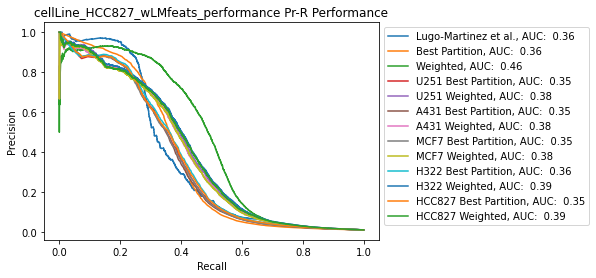

In [ ]:
#plot performance
precRecall_pairs = []
for cmpPerformance in performances4Comparision:
    precRecall_pairs.append(dataProcessing.loadResults_precRecall(cmpPerformance[0], cmpPerformance[1]))
modelEvaluating.plotAnalysis(workDir, 'cellLine_HCC827_wLMfeats_performance', precRecall_pairs)

#Exploration w/ PCA, t-SNE, Overlap, ...

In [ ]:
groundTruth_labelsIntersection.to_csv(LMprotein_complexesDir + 'integrated_test_labels_either_model__groundTruth_U251-MCF7-H322-Intersection.tsv', sep='\t', index=False)

In [ ]:
features_all_intersection_U251_MCF7_H322.to_csv(LMprotein_complexesDir + 'integrated_MM+TSCS+Exp+Abun+Loc_features_test_either_model__U251-MCF7-H322-Intersection.tsv', sep='\t', index=False)

In [ ]:
#trueLabels = pd.read_csv(LMprotein_complexesDir + 'integrated_test_labels_either_model.tsv', sep='\t', usecols=[0])
#trueLabels = pd.read_csv(LMprotein_complexesDir + 'integrated_test_labels_either_model__U251Control.tsv', sep='\t', usecols=[0])
#print('trueLabels shape {0}'.format(trueLabels.shape))
#print('trueLabels head {0}'.format(trueLabels.head()))

#cellLine_acc_agnosticPreds = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/probsPos_acc (1).csv', delimiter=',')
precision_acc, recall_acc, thresholds_acc = precision_recall_curve(groundTruth_labelsIntersection.label, cellLine_acc_agnosticPreds)
print('cellLine_acc_agnosticPreds (from accuracy) shape is {0}'.format(cellLine_acc_agnosticPreds.shape))

#cellLine_weighted_agnosticPreds = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/probsPos_weighted (1).csv', delimiter=',')
precision_weighted, recall_weighted, thresholds_weighted = precision_recall_curve(groundTruth_labelsIntersection.label, cellLine_weighted_agnosticPreds)
print('cellLine_weighted_agnosticPreds (from weighted) shape {0}'.format(cellLine_weighted_agnosticPreds.shape))

cellLine_acc_agnosticPreds (from accuracy) shape is (301356,)
cellLine_weighted_agnosticPreds (from weighted) shape (301356,)


In [ ]:
cellLine_acc_agnosticPreds = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/probsPos_acc (1).csv', delimiter=',')
cellLine_weighted_agnosticPreds = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/probsPos_weighted (1).csv', delimiter=',')

In [ ]:
cellLine_acc_agnosticPreds = cellLine_acc_agnosticPreds[groundTruth_labelsIntersection.index]
cellLine_weighted_agnosticPreds = cellLine_weighted_agnosticPreds[groundTruth_labelsIntersection.index]

In [ ]:
fscore_acc = (2 * precision_acc * recall_acc) / (precision_acc + recall_acc)
ixAcc = np.argmax(fscore_acc)
print('Best Acc Threshold=%f, F-Score=%.3f' % (thresholds_acc[ixAcc], fscore_acc[ixAcc]))

fscore_weighted = (2 * precision_weighted * recall_weighted) / (precision_weighted + recall_weighted)
ixWeighted = np.argmax(fscore_weighted)
print('Best Weighted Threshold=%f, F-Score=%.3f' % (thresholds_weighted[ixWeighted], fscore_weighted[ixWeighted]))


Best Acc Threshold=0.655000, F-Score=0.441
Best Weighted Threshold=0.506423, F-Score=0.481


In [ ]:
ppiPreds_bestThres_acc = cellLine_acc_agnosticPreds
ppiPreds_bestThres_acc[ppiPreds_bestThres_acc >= thresholds_acc[ixAcc]] = 1
ppiPreds_bestThres_acc[ppiPreds_bestThres_acc < thresholds_acc[ixAcc]] = 0
print(np.sum(ppiPreds_bestThres_acc))

ppiPreds_bestThres_weighted = cellLine_weighted_agnosticPreds
ppiPreds_bestThres_weighted[ppiPreds_bestThres_weighted >= thresholds_weighted[ixWeighted]] = 1
ppiPreds_bestThres_weighted[ppiPreds_bestThres_weighted < thresholds_weighted[ixWeighted]] = 0
print(np.sum(ppiPreds_bestThres_weighted))

2203.0
2388.0


In [ ]:
meanDiff_acc = np.empty((301356, 4))
meanDiff_acc[:] = np.nan
meanDiff_acc[:, 0] = ppiPreds_bestThres_acc

meanDiff_weighted = np.empty((301356, 4))
meanDiff_weighted[:] = np.nan
meanDiff_weighted[:, 0] = ppiPreds_bestThres_weighted

In [ ]:
cellLines = ['U251', 'MCF7', 'H322']

In [ ]:
len(cellLine_accPreds)

304074

In [ ]:
cellLine_accPreds = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/probsPos_acc_MCF7.csv', delimiter=',')
cellLine_accPreds = cellLine_accPreds[groundTruth_labelsIntersection.index]
cellLine_weightedPreds = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures/probsPos_weighted_MCF7.csv', delimiter=',')
cellLine_weightedPreds = cellLine_weightedPreds[groundTruth_labelsIntersection.index]

In [ ]:
cellLine_accPreds.shape

(304074,)

In [ ]:
precision_acc, recall_acc, thresholds_acc = precision_recall_curve(groundTruth_labelsIntersection.label, cellLine_accPreds)
precision_weighted, recall_weighted, thresholds_weighted = precision_recall_curve(groundTruth_labelsIntersection.label, cellLine_weightedPreds)

fscore_acc = (2 * precision_acc * recall_acc) / (precision_acc + recall_acc)
ixAcc = np.argmax(fscore_acc)
print('Best Acc Threshold=%f, F-Score=%.3f' % (thresholds_acc[ixAcc], fscore_acc[ixAcc]))

fscore_weighted = (2 * precision_weighted * recall_weighted) / (precision_weighted + recall_weighted)
ixWeighted = np.argmax(fscore_weighted)
print('Best Weighted Threshold=%f, F-Score=%.3f' % (thresholds_weighted[ixWeighted], fscore_weighted[ixWeighted]))

ppiPreds_bestThres_acc = cellLine_accPreds
ppiPreds_bestThres_acc[ppiPreds_bestThres_acc >= thresholds_acc[ixAcc]] = 1
ppiPreds_bestThres_acc[ppiPreds_bestThres_acc < thresholds_acc[ixAcc]] = 0
meanDiff_acc[:, 2] = ppiPreds_bestThres_acc

ppiPreds_bestThres_weighted = cellLine_weightedPreds
ppiPreds_bestThres_weighted[ppiPreds_bestThres_weighted >= thresholds_weighted[ixWeighted]] = 1
ppiPreds_bestThres_weighted[ppiPreds_bestThres_weighted < thresholds_weighted[ixWeighted]] = 0
meanDiff_weighted[:, 2] = ppiPreds_bestThres_weighted

Best Acc Threshold=0.905000, F-Score=0.374
Best Weighted Threshold=1.000000, F-Score=nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
np.quantile(cellLine_weightedPreds, 0.99)

0.7573473651522573

In [ ]:
ppiPreds_bestThres_weighted = cellLine_weightedPreds.copy()
ppiPreds_bestThres_weighted[ppiPreds_bestThres_weighted >= 0.757] = 1
ppiPreds_bestThres_weighted[ppiPreds_bestThres_weighted < 0.757] = 0
meanDiff_weighted[:, 2] = ppiPreds_bestThres_weighted

In [ ]:
np.sum(ppiPreds_bestThres_weighted)

3020.0

In [ ]:
scbc_cellLines = ['A431', 'H322', 'HCC827', 'MCF7', 'U251']
meanDiff_acc = np.empty((546645, 6))
meanDiff_acc[:] = np.nan
meanDiff_acc[:, 0] = ppiPreds_bestThres_acc

meanDiff_weighted = np.empty((546645, 6))
meanDiff_weighted[:] = np.nan
meanDiff_weighted[:, 0] = ppiPreds_bestThres_weighted
col=1
for cellLine in scbc_cellLines:
    
    cellLine_accPreds = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_cellLine_{0}_wLMfeats_performance/probsPos_acc.csv'.format(cellLine), delimiter=',')
    precision_acc, recall_acc, thresholds_acc = precision_recall_curve(trueLabels, cellLine_accPreds)

    cellLine_weightedPreds = np.loadtxt(workDir + 'modelPerformance/modelsPerformance_cellLine_{0}_wLMfeats_performance/probsPos_weighted.csv'.format(cellLine), delimiter=',')
    precision_weighted, recall_weighted, thresholds_weighted = precision_recall_curve(trueLabels, cellLine_weightedPreds)

    fscore_acc = (2 * precision_acc * recall_acc) / (precision_acc + recall_acc)
    ixAcc = np.argmax(fscore_acc)
    print('Best Acc Threshold=%f, F-Score=%.3f' % (thresholds_acc[ixAcc], fscore_acc[ixAcc]))

    fscore_weighted = (2 * precision_weighted * recall_weighted) / (precision_weighted + recall_weighted)
    ixWeighted = np.argmax(fscore_weighted)
    print('Best Weighted Threshold=%f, F-Score=%.3f' % (thresholds_weighted[ixWeighted], fscore_weighted[ixWeighted]))

    ppiPreds_bestThres_acc = cellLine_accPreds
    ppiPreds_bestThres_acc[ppiPreds_bestThres_acc >= thresholds_acc[ixAcc]] = 1
    ppiPreds_bestThres_acc[ppiPreds_bestThres_acc < thresholds_acc[ixAcc]] = 0
    meanDiff_acc[:, col] = ppiPreds_bestThres_acc

    ppiPreds_bestThres_weighted = cellLine_weightedPreds
    ppiPreds_bestThres_weighted[ppiPreds_bestThres_weighted >= thresholds_weighted[ixWeighted]] = 1
    ppiPreds_bestThres_weighted[ppiPreds_bestThres_weighted < thresholds_weighted[ixWeighted]] = 0
    meanDiff_weighted[:, col] = ppiPreds_bestThres_weighted
    
    col+=1

Best Acc Threshold=0.762500, F-Score=0.414
Best Weighted Threshold=0.655021, F-Score=0.443
Best Acc Threshold=0.752500, F-Score=0.423
Best Weighted Threshold=0.661271, F-Score=0.455
Best Acc Threshold=0.752500, F-Score=0.419
Best Weighted Threshold=0.665764, F-Score=0.451
Best Acc Threshold=0.757500, F-Score=0.415
Best Weighted Threshold=0.660076, F-Score=0.445
Best Acc Threshold=0.760000, F-Score=0.416
Best Weighted Threshold=0.653008, F-Score=0.448


In [ ]:
meanDiff_weighted.shape

(301356, 4)

In [ ]:
meanDiff_accOverlap = meanDiff_acc
meanDiff_accOverlap[:] = 0
meanDiff_weightedOverlap = meanDiff_weighted
meanDiff_weightedOverlap[:] = 0

In [ ]:
for i in np.arange(1, 6):
  meanDiff_accOverlap[np.argwhere(meanDiff_acc[:, 0] > 0) == np.argwhere(meanDiff_acc[:, i] > 0), i] = 1 
  meanDiff_weightedOverlap[np.argwhere(meanDiff_weighted[:, 0] > 0) == np.argwhere(meanDiff_weighted[:, i] > 0), i] = 1   

IndexError: ignored

In [ ]:
meanDiff_acc[:5, :]

array([[0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1.]])

In [ ]:
print(np.absolute(np.array(accList)-6302))
print(np.absolute(np.array(weightedList)-6302))

[2198. 1990. 1906. 2034. 2078.]
[2514. 2558. 2583. 2467. 2383.]


In [ ]:
trueLabels.sum()

0    6302
dtype: int64

In [ ]:
print(np.sum(cellLine_acc_agnosticPreds))
print(np.sum(cellLine_weighted_agnosticPreds))

5311.0
4009.0


In [ ]:
col = 1
meanDiff_acc = np.empty((546645, 6))
meanDiff_acc[:] = np.nan
meanDiff_acc[:, 0] = cellLine_acc_agnosticPreds

meanDiff_weighted = np.empty((546645, 6))
meanDiff_weighted[:] = np.nan
meanDiff_weighted[:, 0] = cellLine_weighted_agnosticPreds

print('# nans in allocated acc space: {0}'.format(np.count_nonzero(np.isnan(meanDiff_acc))))
print('# nans in allocated weighted space: {0}'.format(np.count_nonzero(np.isnan(meanDiff_weighted))))

newName = 'cellLine_*_wLMfeats_performance/'
scbc_cellLines = sorted(['U251', 'A431', 'MCF7', 'H322', 'HCC827'])
cellLine_acc_specificPreds_all = sorted(glob.glob(workDir + 'modelPerformance/modelsPerformance_{0}/'.format(newName) + 'probsPos_acc.csv'))
cellLine_weighted_specificPreds_all = sorted(glob.glob(workDir + 'modelPerformance/modelsPerformance_{0}/'.format(newName) + 'probsPos_weighted.csv'))
for cellLine, cellLine_specificPred_accPath, cellLine_specificPred_weightedPath in zip(scbc_cellLines, cellLine_acc_specificPreds_all, cellLine_weighted_specificPreds_all):
    cellLine_acc_specificPred = np.loadtxt(cellLine_specificPred_accPath, delimiter=',')
    print('cellLine {0} (from accuracy) specificPred shape {1}'.format(cellLine, cellLine_acc_specificPred.shape))
    cellLine_weighted_specificPred = np.loadtxt(cellLine_specificPred_weightedPath, delimiter=',')
    print('cellLine {0} (from weighted) specificPred shape {1}'.format(cellLine, cellLine_weighted_specificPred.shape))

    meanDiff_acc[:, col] = cellLine_acc_specificPred   
    meanDiff_weighted[:, col] = cellLine_weighted_specificPred
    col+=1

print('# nans in allocated acc space: {0}'.format(np.count_nonzero(np.isnan(meanDiff_acc))))
print('# nans in allocated weighted space: {0}'.format(np.count_nonzero(np.isnan(meanDiff_weighted))))

# nans in allocated acc space: 2733225
# nans in allocated weighted space: 2733225
cellLine A431 (from accuracy) specificPred shape (546645,)
cellLine A431 (from weighted) specificPred shape (546645,)
cellLine H322 (from accuracy) specificPred shape (546645,)
cellLine H322 (from weighted) specificPred shape (546645,)
cellLine HCC827 (from accuracy) specificPred shape (546645,)
cellLine HCC827 (from weighted) specificPred shape (546645,)
cellLine MCF7 (from accuracy) specificPred shape (546645,)
cellLine MCF7 (from weighted) specificPred shape (546645,)
cellLine U251 (from accuracy) specificPred shape (546645,)
cellLine U251 (from weighted) specificPred shape (546645,)
# nans in allocated acc space: 0
# nans in allocated weighted space: 0


In [ ]:
meanDiff_accDF_justCellLines = pd.DataFrame(meanDiff_acc[:, 1:], columns=['U251', 'MCF7', 'H322'])
meanDiff_weightedDF_justCellLines = pd.DataFrame(meanDiff_weighted[:, 1:], columns=['U251', 'MCF7', 'H322'])

In [ ]:
meanDiff_accDF = pd.DataFrame(meanDiff_acc, columns=['Agnostic', 'U251', 'MCF7', 'H322'])
meanDiff_weightedDF = pd.DataFrame(meanDiff_weighted, columns=['Agnostic', 'U251', 'MCF7', 'H322'])

In [ ]:
meanDiff_accDF_justCellLines_overlap.shape

(5694, 3)

In [ ]:
meanDiff_accDF_justCellLines_overlap = meanDiff_accDF_justCellLines.loc[meanDiff_accDF_justCellLines.sum(axis=1) > 0, :]
meanDiff_weightedDF_justCellLines_overlap = meanDiff_weightedDF_justCellLines.loc[meanDiff_weightedDF_justCellLines.sum(axis=1) > 0, :]
meanDiff_accDF_overlap = meanDiff_accDF.loc[meanDiff_accDF.sum(axis=1) > 0, :]
meanDiff_weightedDF_overlap = meanDiff_weightedDF.loc[meanDiff_weightedDF.sum(axis=1) > 0, :]

In [ ]:
meanDiff_accDF_justCellLines_overlapCount = np.empty((3, 3))
meanDiff_weightedDF_justCellLines_overlapCount = np.empty((3, 3))
meanDiff_accDF_overlapCount = np.empty((4, 4))
meanDiff_weightedDF_overlapCount = np.empty((4, 4))

In [ ]:
meanDiff_accDF_justCellLines_overlapCount[:] = np.nan
meanDiff_weightedDF_justCellLines_overlapCount[:] = np.nan
meanDiff_accDF_overlapCount[:] = np.nan
meanDiff_weightedDF_overlapCount[:] = np.nan

In [ ]:
for x in np.arange(4):
  for y in np.arange(4):
    pairOnes = meanDiff_weightedDF_overlap.iloc[:, [x, y]].loc[(meanDiff_weightedDF_overlap.iloc[:, x]==1) & (meanDiff_weightedDF_overlap.iloc[:, y]==1)]
    meanDiff_weightedDF_overlapCount[x, y] = len(pairOnes.loc[pairOnes.iloc[:, 0]==pairOnes.iloc[:, 1]])/np.amin([])

In [ ]:
meanDiff_accDF_justCellLines_overlapCount

array([[1975.,  389.,  408.],
       [ 389., 2369.,  456.],
       [ 408.,  456., 2431.]])

In [ ]:
meanDiff_weightedDF_justCellLines_overlapCount

array([[1861.,  410.,  372.],
       [ 410., 3020.,  460.],
       [ 372.,  460., 2181.]])

In [ ]:
meanDiff_accDF_overlapCount

array([[2203.,  381.,  403.,  435.],
       [ 381., 1975.,  389.,  408.],
       [ 403.,  389., 2369.,  456.],
       [ 435.,  408.,  456., 2431.]])

In [ ]:
meanDiff_weightedDF_overlapCount

array([[2388.,  426.,  492.,  492.],
       [ 426., 1861.,  410.,  372.],
       [ 492.,  410., 3020.,  460.],
       [ 492.,  372.,  460., 2181.]])

In [ ]:
def findFraction_overlap(table):

  newTable = table.copy()
  for i in np.arange(table.shape[0]):
    for j in np.arange(table.shape[1]):
      newTable[i, j] = table[i, j]/np.amin([
                                            table[i, i], 
                                            table[j, j]
      ])

  return newTable

In [ ]:
meanDiff_accDF_justCellLines_overlapCount_frac=findFraction_overlap(meanDiff_accDF_justCellLines_overlapCount)

In [ ]:
meanDiff_weightedDF_justCellLines_overlapCount_frac=findFraction_overlap(meanDiff_weightedDF_justCellLines_overlapCount)

In [ ]:
meanDiff_accDF_overlapCount_frac=findFraction_overlap(meanDiff_accDF_overlapCount)

In [ ]:
meanDiff_weightedDF_overlapCount_frac=findFraction_overlap(meanDiff_weightedDF_overlapCount)

In [ ]:
meanDiff_accDF = pd.DataFrame(meanDiff_accDF_overlapCount_frac, columns=['Cell-line Agnostic', 'U251', 'MCF7', 'H322'])
meanDiff_weightedDF = pd.DataFrame(meanDiff_weightedDF_overlapCount_frac, columns=['Cell-line Agnostic', 'U251', 'MCF7', 'H322'])

meanDiff_accDF_justCellLines = pd.DataFrame(meanDiff_accDF_justCellLines_overlapCount_frac, columns=['U251', 'MCF7', 'H322'])
meanDiff_weightedDF_justCellLines = pd.DataFrame(meanDiff_weightedDF_justCellLines_overlapCount_frac, columns=['U251', 'MCF7', 'H322'])

In [ ]:
meanDiff_accDF_cellLine_corr = meanDiff_accDF.corr()
meanDiff_weightedDF_cellLine_corr = meanDiff_weightedDF.corr()

In [ ]:
meanDiff_accDF_justCellLines_corr = meanDiff_accDF_justCellLines.corr()
meanDiff_weightedDF_justCellLines_corr = meanDiff_weightedDF_justCellLines.corr()

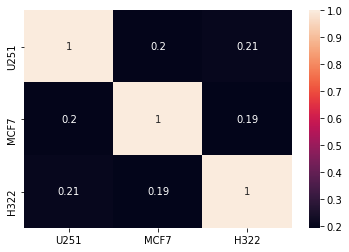

In [ ]:
plt.clf()
sns.heatmap(meanDiff_accDF_justCellLines, 
        xticklabels=meanDiff_accDF_justCellLines.columns,
        yticklabels=meanDiff_accDF_justCellLines.columns,
        annot=True)

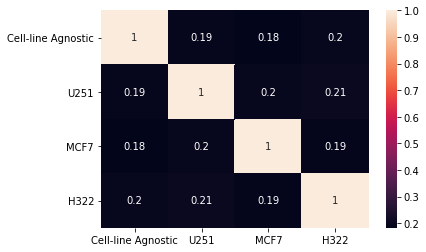

In [ ]:
plt.clf()
sns.heatmap(meanDiff_accDF, 
        xticklabels=meanDiff_accDF.columns,
        yticklabels=meanDiff_accDF.columns,
        annot=True)

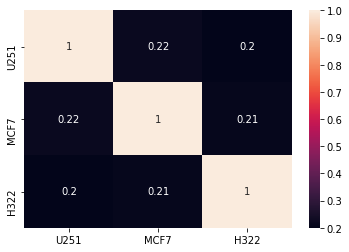

In [ ]:
plt.clf()
sns.heatmap(meanDiff_weightedDF_justCellLines, 
        xticklabels=meanDiff_weightedDF_justCellLines.columns,
        yticklabels=meanDiff_weightedDF_justCellLines.columns,
        annot=True)

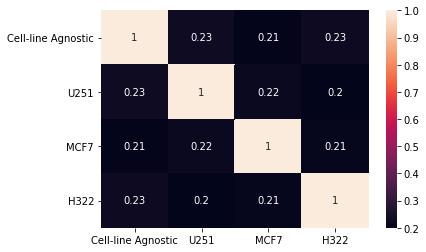

In [ ]:
plt.clf()
sns.heatmap(meanDiff_weightedDF, 
        xticklabels=meanDiff_weightedDF.columns,
        yticklabels=meanDiff_weightedDF.columns,
        annot=True)

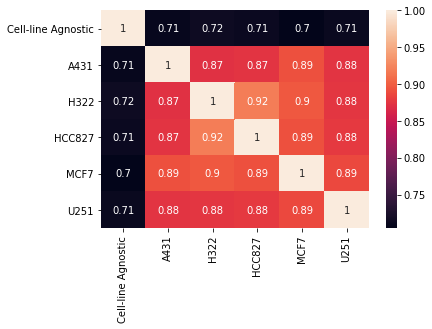

In [ ]:
plt.clf()
sns.heatmap(meanDiff_weightedDF_cellLine_corr, 
        xticklabels=meanDiff_weightedDF_cellLine_corr.columns,
        yticklabels=meanDiff_weightedDF_cellLine_corr.columns,
        annot=True)

In [ ]:
print(np.absolute(np.sum(meanDiff_acc, axis=0)-6302))
print(np.absolute(np.sum(meanDiff_weighted, axis=0)-6302))

[ 991. 4214. 4127. 4456. 4392. 4482.]
[2293. 1473. 1504. 1679. 1764. 1757.]


In [ ]:
LMpreds = pd.read_csv('pairwise_predicted_scores.txt', sep='\t')
print(LMpreds.shape)
print(LMpreds.head())

(10800800, 2)
   114781,114787  0.47941
0  114787,114789  0.48046
1   114787,28991  0.47972
2   114787,28992  0.49071
3   114787,55293  0.48293
4   114787,55297  0.49071


In [ ]:
scbc_cellLines = ['Cell-line Agnostic', 'A431', 'H322', 'HCC827', 'MCF7', 'U251']

In [ ]:
np.amin(meanDiff_acc)

0.0

(546645, 5)
columns wanted ... [1, 2, 3, 4]
subtracting column wanted=1
subtracting column wanted=2
subtracting column wanted=3
subtracting column wanted=4
columns wanted ... [0, 2, 3, 4]
subtracting column wanted=0
subtracting column wanted=2
subtracting column wanted=3
subtracting column wanted=4
columns wanted ... [0, 1, 3, 4]
subtracting column wanted=0
subtracting column wanted=1
subtracting column wanted=3
subtracting column wanted=4
columns wanted ... [0, 1, 2, 4]
subtracting column wanted=0
subtracting column wanted=1
subtracting column wanted=2
subtracting column wanted=4
columns wanted ... [0, 1, 2, 3]
subtracting column wanted=0
subtracting column wanted=1
subtracting column wanted=2
subtracting column wanted=3


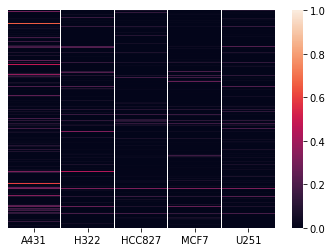

In [ ]:
print(meanDiff_acc.shape)
for cellLine, cellLine_num in zip(scbc_cellLines, np.arange(5)):
    plt.clf()
    pairWise_diffs = meanDiff_acc
    colsWanted = [col for col in np.arange(meanDiff_acc.shape[1]) if col != cellLine_num]
    print('columns wanted ... {0}'.format(colsWanted))

    for colWanted in colsWanted:
        print('subtracting column wanted={0}'.format(colWanted))
        pairWise_diffs[:, colWanted] = np.absolute(pairWise_diffs[:, colWanted] - pairWise_diffs[:, cellLine_num])
          
    ppiPred_pairWise_accDiffs = pd.DataFrame(pairWise_diffs, columns=scbc_cellLines)
    sns.heatmap(ppiPred_pairWise_accDiffs, yticklabels=False, xticklabels=scbc_cellLines)
    plt.savefig("ppiPred_pairWise_accDiffs--{0}.png".format(cellLine))

In [ ]:
ppiPred_pairWise_accDiffs.iloc[:5, :]

A431      H322    HCC827      MCF7      U251
0  0.014995  0.033459  0.128522  0.009916  0.033725
1  0.897195  0.000000  0.000000  0.000000  0.000000
2  0.689477  0.000000  0.000000  0.000000  0.000000
3  0.841554  0.000000  0.000000  0.000000  0.000000
4  0.555037  0.013161  0.000000  0.000000  0.000000

(546645, 5)
columns wanted ... [1, 2, 3, 4]
subtracting column wanted=1
subtracting column wanted=2
subtracting column wanted=3
subtracting column wanted=4
columns wanted ... [0, 2, 3, 4]
subtracting column wanted=0
subtracting column wanted=2
subtracting column wanted=3
subtracting column wanted=4
columns wanted ... [0, 1, 3, 4]
subtracting column wanted=0
subtracting column wanted=1
subtracting column wanted=3
subtracting column wanted=4
columns wanted ... [0, 1, 2, 4]
subtracting column wanted=0
subtracting column wanted=1
subtracting column wanted=2
subtracting column wanted=4
columns wanted ... [0, 1, 2, 3]
subtracting column wanted=0
subtracting column wanted=1
subtracting column wanted=2
subtracting column wanted=3


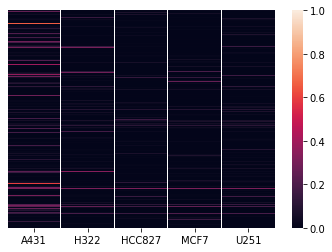

In [ ]:
print(meanDiff_weighted.shape)
for cellLine, cellLine_num in zip(scbc_cellLines, np.arange(5)):
    plt.clf()
    pairWise_diffs = meanDiff_weighted
    colsWanted = [col for col in np.arange(meanDiff_weighted.shape[1]) if col != cellLine_num]
    print('columns wanted ... {0}'.format(colsWanted))

    for colWanted in colsWanted:
        print('subtracting column wanted={0}'.format(colWanted))
        pairWise_diffs[:, colWanted] = np.absolute(pairWise_diffs[:, colWanted] - pairWise_diffs[:, cellLine_num])
          
    ppiPred_pairWise_accDiffs = pd.DataFrame(pairWise_diffs, columns=scbc_cellLines)
    sns.heatmap(ppiPred_pairWise_accDiffs, yticklabels=False, xticklabels=scbc_cellLines)
    plt.savefig("ppiPred_pairWise_weightedDiffs--{0}.png".format(cellLine))

In [ ]:
print(meanDiff_acc.shape)
ppiPred_accDiffs = pd.DataFrame(meanDiff_acc, columns=scbc_cellLines)
#sns.heatmap(ppiPred_accDiffs, yticklabels=False, xticklabels=scbc_cellLines)

(546645, 5)


In [ ]:
pcaAcc = PCA().fit(ppiPred_accDiffs)
ppiPred_accDiffs.insert(0, 'indices', np.arange(len(meanDiff_acc)))
print(ppiPred_accDiffs.iloc[:5, :])

   indices  Cell-line Agnostic    A431    H322  HCC827    MCF7    U251
0        0              0.0000  0.0225  0.5000  0.1275  0.0025  0.1925
1        1              1.0000  1.0000  1.0000  1.0000  1.0000  1.0000
2        2              0.7550  0.7500  0.7500  0.7500  0.7500  0.7500
3        3              0.9875  0.9875  0.9875  0.9875  0.9875  0.9875
4        4              0.2075  0.8825  0.9175  0.9175  0.9175  0.9175


([], <a list of 0 Text major ticklabel objects>)

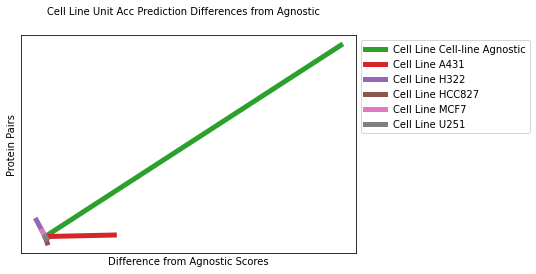

In [ ]:
fig = plt.figure()
fig.suptitle("Cell Line Unit Acc Prediction Differences from Agnostic", fontsize=10)
for i, (comp, var) in enumerate(zip(pcaAcc.components_, pcaAcc.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]], label=f"Cell Line {scbc_cellLines[i]}", linewidth=5, zorder=i+100,
             color=f"C{i + 2}")

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1) 
plt.xlabel('Difference from Agnostic Scores')   
plt.xticks([])
plt.ylabel('Protein Pairs')
plt.yticks([])

In [ ]:
tsneAcc_results = TSNE().fit_transform(ppiPred_accDiffs)
print(tsneAcc_results.shape)

'''
tsneAcc_results = pd.DataFrame(tsneAcc_results, columns=['])
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)
'''

In [ ]:
tsneAcc_resultsDF = pd.DataFrame(tsneAcc_results)

sns.scatterplot(
    hue='1',
    palette=sns.color_palette("hls", 5),
    data=tsneAcc_resultsDF,
    legend="full",
    alpha=0.3
)

In [ ]:
print(meanDiff_weighted.shape)
ppiPred_weightedDiffs = pd.DataFrame(meanDiff_weighted, columns=scbc_cellLines)
#sns.heatmap(ppiPred_weightedDiffs, yticklabels=False, xticklabels=scbc_cellLines)

(546645, 5)


In [ ]:
tsneWeighted_results = TSNE().fit_transform(meanDiff_weighted)
print(tsneWeighted_results.shape)

'''
sns.scatterplot(data=tsneWeighted_results)
'''

In [ ]:
pcaWeighted = PCA().fit(ppiPred_weightedDiffs)
ppiPred_weightedDiffs.insert(0, 'indices', np.arange(len(meanDiff_acc)))
print(ppiPred_weightedDiffs.iloc[:5, :])

   indices  Cell-line Agnostic      A431  ...    HCC827      MCF7      U251
0        0            0.018397  0.018995  ...  0.062902  0.018730  0.052986
1        1            0.876759  0.897195  ...  0.897195  0.897195  0.897195
2        2            0.620843  0.689477  ...  0.689477  0.689477  0.689477
3        3            0.841554  0.841554  ...  0.841554  0.841554  0.841554
4        4            0.593600  0.568198  ...  0.581358  0.581358  0.581358

[5 rows x 7 columns]


([], <a list of 0 Text major ticklabel objects>)

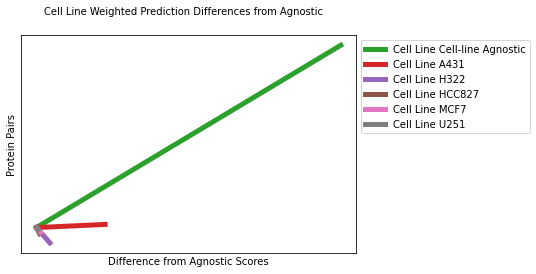

In [ ]:
fig = plt.figure()
fig.suptitle("Cell Line Weighted Prediction Differences from Agnostic", fontsize=10)
for i, (comp, var) in enumerate(zip(pcaWeighted.components_, pcaWeighted.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot([0, comp[0]], [0, comp[1]], label=f"Cell Line {scbc_cellLines[i]}", linewidth=5, zorder=i+100,
             color=f"C{i + 2}")

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1) 
plt.xlabel('Difference from Agnostic Scores')   
plt.xticks([])
plt.ylabel('Protein Pairs')
plt.yticks([])

In [ ]:
expName = 'ppiPrediction_performanceAnalysis_lugoMartinez_integratedFeatures'
newName = 'cellLine_HCC827_wLMfeats_performance'
os.makedirs(workDir + 'models/models_{0}/'.format(newName))
modelFiles = sorted(glob.glob(workDir + 'models/models_{0}/'.format(expName) + 'model_{0}_Partition_*.pkl'.format(expName)))

In [ ]:
originPath = '/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/code/code_toPublish/batchCode/A431 Cell Line Specific Assessment BR0.ipynb'
for copy in np.arange(1, 24):
  newPath = '/content/drive/My Drive/Colab Notebooks/Primary Research/JLMwSCBC_notebook/code/code_toPublish/batchCode/A431 Cell Line Specific Assessment BR{0}.ipynb'.format(copy)
  shutil.copy(originPath, newPath)

In [ ]:
fold=4
ppiPrediction_v2.run(workDir, 
                     dir + 'trainingData.tsv', dir + 'trainingLabels.tsv', 
                     dir + 'testData.tsv', dir + 'testLabels.tsv', 
                     expName='origPairs_drewPlus+SCBC_recheck_5CV_{0}'.format(fold),
                     modelChunk_incr=165, modelStart_interval=22,
                     modelingOnly=True, parallelProcessing=True)

Loading data...
The shape of the data is (181964, 276)
The shape of labels is (181964, 1)
Completed loading data
________________________________________________
Loading data...
The shape of the data is (45490, 276)
The shape of labels is (45490, 1)
Completed loading data
________________________________________________
Training models per partition of the training data
____________________________________________________________
Progress: 3630/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400building tree 7 of 400
building tree 8 of 400

building tree 9 of 400
building tree 10 of 400building tree 11 of 400

building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.4s


building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    0.7s


building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400building tree 95 of 400
building tree 96 of 400

building tree 97 of 400building tree 98 of 400

building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.9s


building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400building tree 142 of 400

building tree 143 of 400building tree 144 of 400
building tree 145 of 400

building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    1.1s


building tree 153 of 400
building tree 154 of 400building tree 155 of 400

building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400building tree 172 of 400

building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.3s


building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400building tree 197 of 400

building tree 198 of 400building tree 199 of 400

building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    1.6s


building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400building tree 248 of 400

building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400building tree 270 of 400

building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400building tree 276 of 400



[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.9s


building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400building tree 287 of 400

building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400building tree 304 of 400

building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    2.2s



building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400building tree 350 of 400
building tree 351 of 400

building tree 352 of 400
building tree 353 of 400
building tree 354 of 400building tree 355 of 400

building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    2.6s


building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400building tree 375 of 400

building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400building tree 389 of 400

building tree 390 of 400
building tree 391 of 400
building tree 392 of 400building tree 393 of 400

building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.7s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3631/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400building tree 6 of 400

building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.4s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400building tree 79 of 400

building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    0.7s


building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400building tree 96 of 400

building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.9s


building tree 112 of 400
building tree 113 of 400
building tree 114 of 400building tree 115 of 400

building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400building tree 125 of 400
building tree 126 of 400

building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400building tree 139 of 400

building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    1.1s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400building tree 158 of 400

building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400building tree 169 of 400

building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400building tree 180 of 400

building tree 181 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.4s


building tree 203 of 400
building tree 204 of 400building tree 205 of 400

building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    1.7s


building tree 233 of 400building tree 234 of 400

building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400building tree 260 of 400

building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.0s


building tree 262 of 400building tree 263 of 400

building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400building tree 300 of 400

building tree 301 of 400b

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    2.4s


building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400building tree 325 of 400

building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400building tree 332 of 400

building tree 333 of 400
building tree 334 of 400
building tree 335 of 400building tree 336 of 400

building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400building tree 348 of 400

building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    2.8s


building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400building tree 388 of 400

building tree 389 of 400
building tree 390 of 400building tree 391 of 400building tree 392 of 400


building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.9s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3632/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.2s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400building tree 19 of 400

building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400building tree 27 of 400

building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.4s



building tree 74 of 400

building tree 75 of 400
building tree 76 of 400
building tree 77 of 400building tree 78 of 400

building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400building tree 85 of 400

building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400building tree 111 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    0.6s



building tree 112 of 400
building tree 113 of 400building tree 114 of 400

building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400building tree 124 of 400

building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400building tree 135 of 400

building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    0.8s


building tree 142 of 400building tree 143 of 400

building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400building tree 159 of 400

building tree 160 of 400
building tree 161 of 400
building tree 162 of 400building tree 163 of 400

building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400building tree 172 of 400

building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    1.0s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400building tree 186 of 400

building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400building tree 208 of 400

building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:    1.2s


building tree 218 of 400

building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400building tree 230 of 400

building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400building tree 242 of 400

building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400building tree 247 of 400

building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:    1.5s


building tree 255 of 400
building tree 256 of 400building tree 257 of 400

building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400building tree 276 of 400
building tree 277 of 400

building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    1.7s


building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400building tree 296 of 400

building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400building tree 315 of 400
building tree 316 of 400

building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:    2.0s


building tree 363 of 400building tree 364 of 400

building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400building tree 371 of 400

building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400building tree 392 of 400building tree 393 of 400

building tree 394 of 400

building tree 395 of 400
building tree 396 of 400building tree 397 of 400



[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.3s finished


building tree 398 of 400
building tree 399 of 400
building tree 400 of 400
Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3633/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400building tree 36 of 400

building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
b

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.4s


building tree 62 of 400

building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400building tree 69 of 400

building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400building tree 85 of 400

building tree 86 of 400
building tree 87 of 400
building tree 88 of 400

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    0.7s



building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400building tree 94 of 400
building tree 95 of 400
building tree 96 of 400

building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.9s


building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    1.2s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400building tree 170 of 400

building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400building tree 175 of 400

building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.4s


building tree 197 of 400building tree 198 of 400

building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400building tree 220 of 400

building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    1.8s


building tree 225 of 400building tree 226 of 400

building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400building tree 263 of 400

building tree 264 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.1s


building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400building tree 282 of 400

building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400building tree 297 of 400

building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400building tree 302 of 400

building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    2.5s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    2.9s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400building tree 365 of 400

building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400building tree 386 of 400
building tree 387 of 400

building tree 388 of 400
building tree 389 of 400building tree 390 of 400building tree 391 of 400


building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.0s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3634/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400building tree 7 of 400

building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400building tree 16 of 400

building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400building tree 32 of 400

building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400building tree 37 of 400

building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400building tree 42 of 400

b

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.4s


building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400building tree 67 of 400

building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400building tree 83 of 400

building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    0.7s



building tree 92 of 400
building tree 93 of 400
building tree 94 of 400building tree 95 of 400

building tree 96 of 400
building tree 97 of 400
building tree 98 of 400building tree 99 of 400

building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.8s


building tree 121 of 400
building tree 122 of 400
building tree 123 of 400building tree 124 of 400

building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400building tree 142 of 400

building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    1.1s


building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400building tree 166 of 400

building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.4s


building tree 178 of 400building tree 179 of 400building tree 180 of 400


building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400building tree 200 of 400

building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400building tree 211 of 400

building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    1.7s


building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400building tree 254 of 400
building tree 255 of 400

building tree 256 of 400
building tree 257 of 400
building tree 258 of 400building tree 259 of 400

building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.0s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400building tree 270 of 400

building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    2.4s


building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400building tree 342 of 400

building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400building tree 359 of 400

building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    2.7s


building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3635/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400building tree 6 of 400

building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400building tree 25 of 400

building tree 26 of 400
building tree 27 of 400building tree 28 of 400

building tree 29 of 400building tree 30 of 400

building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400building tree 39 of 400
building tree 40 of 400

building tree 41 of 400building tree 42 of 400
bu

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.4s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400building tree 82 of 400building tree 83 of 400


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400building tree 99 of 400

building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    0.7s


building tree 105 of 400building tree 106 of 400

building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400building tree 122 of 400

building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400building tree 127 of 400

building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    0.8s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400building tree 145 of 400

building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400building tree 158 of 400

building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400building tree 166 of 400

building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    1.1s


building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400building tree 179 of 400

building tree 180 of 400
building tree 181 of 400
building tree 182 of 400building tree 183 of 400

building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400building tree 199 of 400

building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:    1.3s



building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400building tree 224 of 400

building tree 225 of 400building tree 226 of 400

building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400building tree 235 of 400

building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400building tree 245 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:    1.5s



building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    1.9s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400building tree 320 of 400
building tree 321 of 400

building tree 322 of 400
building tree 323 of 400
building tree 324 of 400building tree 325 of 400

building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400building tree 332 of 400

building tree 333 of 400
building tree 334 of 400building tree 335 of 400

building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:    2.2s


building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400building tree 356 of 400

building tree 357 of 400
building tree 358 of 400
building tree 359 of 400building tree 360 of 400

building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400building tree 380 of 400
building tree 381 of 400
building tree 382 of 400

building tree 383 of 400
building tree 384 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.4s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3636/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400building tree 34 of 400

building tree 35 of 400
building tree 36 of 400building tree 37 of 400

building tree 38 of 400
building tree 39 of 400
building tree 40 of 400building tree 41 of 400

building tree 42 of 400
b

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    0.3s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400building tree 83 of 400

building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400building tree 94 of 400

building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400building tree 99 of 400



[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    0.7s


building tree 100 of 400
building tree 101 of 400
building tree 102 of 400building tree 103 of 400

building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400building tree 110 of 400

building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400building tree 119 of 400

building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    0.9s


building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400building tree 149 of 400

building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    1.1s



building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400building tree 192 of 400

building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:    1.4s


building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400building tree 225 of 400

building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:    1.6s


building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400building tree 299 of 400

building tree 300 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    1.9s


building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400building tree 317 of 400

building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400building tree 326 of 400

building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:    2.2s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400building tree 368 of 400

building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.5s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3637/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s


building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.1s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   15.6s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.7s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   22.3s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   25.9s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   30.0s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   34.5s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   39.2s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   44.1s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   50.2s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   55.3s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.0min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.1min


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.2min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.3min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.5min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.6min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.8min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.9min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3638/3952 
Fitting model to data...
building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.9s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400building tree 57 of 400

building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.3s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.8s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.6s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.3s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   22.6s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   25.8s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   29.3s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.7s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   37.1s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.0s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   45.8s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   50.2s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   55.0s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   59.9s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.4min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3639/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.4s


building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.2s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.8s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.2s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.4s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   20.2s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   24.8s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   28.7s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   33.4s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   37.4s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   43.3s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.1s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   53.9s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   59.6s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.1min


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.2min


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400building tree 247 of 400

building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.3min


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.5min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.6min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.7min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.8min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  2.0min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400building tree 396 of 400

building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3640/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s


building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.1s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.1s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   14.0s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.6s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   19.9s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   22.9s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   26.8s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   30.7s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   34.8s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   39.1s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   43.8s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.5s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   53.9s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   59.2s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.1min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.3min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.4min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.7min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3641/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.0s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.4s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.1s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.7s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.6s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.7s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   25.2s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   28.6s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.6s


building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.3s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   41.1s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.3s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   50.4s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   55.2s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.0min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400building tree 359 of 400

building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.6min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3642/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400building tree 16 of 400



[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.2s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.8s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.0s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.1s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.9s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   24.5s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   28.0s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.0s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.7s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   40.4s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.6s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   49.6s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   54.4s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   59.5s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3643/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.5s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.9s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.8s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.9s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   24.3s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   27.8s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   31.8s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.6s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   40.1s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.2s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   49.2s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   54.0s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   59.3s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400building tree 312 of 400

building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3644/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.0s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.8s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.4s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.7s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   27.1s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   30.6s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.1s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   38.4s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.5s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   47.1s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   51.5s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   56.4s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3645/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.5s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.8s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.9s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.1s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   24.3s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   27.9s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.0s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.6s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   40.2s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.7s


building tree 196 of 400building tree 197 of 400

building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   49.2s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   53.8s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   59.0s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3646/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.8s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400building tree 56 of 400

building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.3s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.8s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.5s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.3s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.8s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   27.3s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   31.0s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.6s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   38.9s


building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.9s


building tree 196 of 400
building tree 197 of 400building tree 198 of 400

building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   47.5s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   52.1s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   57.0s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3647/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400

building tree 3 of 400
building tree 4 of 400
building tree 5 of 400building tree 6 of 400

building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.8s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.3s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.8s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.5s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.4s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.3s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   24.9s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   28.5s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.2s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.6s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   41.0s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.5s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   50.3s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   55.0s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.0min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400building tree 385 of 400

building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.6min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3648/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.5s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.2s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.2s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.1s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   24.7s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   28.2s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.1s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.1s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   40.6s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.9s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   49.7s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   54.2s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   59.7s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 284 of 400building tree 285 of 400

building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3649/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400building tree 14 of 400

building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.5s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.8s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.7s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.4s



building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.9s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   27.4s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   30.8s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.7s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   39.0s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.3s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   48.1s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   52.8s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   57.9s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400building tree 324 of 400

building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3650/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.0s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.5s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.5s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.8s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   25.3s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   28.9s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.9s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.2s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   41.4s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.6s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   50.5s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   55.6s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.0min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.6min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3651/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.7s


building tree 9 of 400building tree 10 of 400

building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.3s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.8s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.4s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.5s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   22.3s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   26.6s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   30.4s


building tree 93 of 400building tree 94 of 400

building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   35.9s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   40.8s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   46.7s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   52.1s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   58.8s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.2min


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.3min


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.5min


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.6min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.7min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.9min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.0min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  2.2min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3652/3952 
Fitting model to data...
building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.3s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.0s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.6s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.1s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.5s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   27.3s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   31.9s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   35.9s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   41.5s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   46.5s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   52.3s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   57.6s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.1min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.2min


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.3min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.4min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.5min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.7min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.8min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400building tree 389 of 400



[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.9min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.0min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3653/3952 
Fitting model to data...
building tree 1 of 400building tree 2 of 400
building tree 3 of 400
building tree 4 of 400



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.7s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.5s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.8s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.6s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.0s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   20.0s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   24.0s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   28.2s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   32.9s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   37.4s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   42.8s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   48.0s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   54.3s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   59.7s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.1min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.2min


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.3min


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.5min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400building tree 298 of 400

building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.6min


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.7min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.8min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  2.0min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3654/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400building tree 4 of 400


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.7s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400building tree 31 of 400

building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.5s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.8s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.3s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.3s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.3s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.9s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   31.5s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   35.9s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   40.7s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   45.7s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   51.1s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.5s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.0min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.1min


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.3min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.4min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.5min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.6min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.9min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.9min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3655/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.2s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.0s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.0s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   15.7s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.6s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   22.4s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   25.8s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   30.3s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   34.8s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400building tree 142 of 400



[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   39.6s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   44.5s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   49.8s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   55.2s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.0min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.1min


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.2min


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.3min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.5min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400building tree 318 of 400

building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.6min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.8min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.9min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3656/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.2s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.9s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.0s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   15.2s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.2s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   22.1s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   25.5s



building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   29.7s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   34.1s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   39.0s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   43.6s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   49.2s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.5s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400building tree 204 of 400

building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.0min


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.1min


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.2min


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.3min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.4min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.6min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.8min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.9min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3657/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.7s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.4s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.2s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.0s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   22.8s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.2s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   30.4s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   34.8s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   39.3s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   44.1s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   49.7s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   55.1s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.0min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.1min


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.2min


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.3min


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.4min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.6min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.8min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.9min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3658/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.6s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.2s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   16.0s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   18.9s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   22.8s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.7s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   31.0s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   35.5s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   40.4s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   45.2s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   50.9s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.5s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.0min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.1min


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.3min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.4min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.5min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.6min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.9min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.9min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3659/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.4s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.8s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.3s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.3s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   15.8s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   19.3s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   23.0s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   26.5s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   31.4s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   35.7s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   40.4s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   45.6s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   50.4s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.0s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:  1.0min


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:  1.1min


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.2min


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.4min


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.5min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.6min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.7min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.9min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.9min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3660/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s


building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.8s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.8s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.6s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.2s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.5s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.8s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   25.7s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   29.4s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400building tree 130 of 400

building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   33.2s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   37.3s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   42.0s


building tree 178 of 400

building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   46.5s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   51.3s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   56.3s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.0min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 285 of 400building tree 286 of 400

building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.6min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3661/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.3s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.1s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.6s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.3s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.0s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.7s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.8s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   30.7s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.6s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   38.3s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.7s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   47.0s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   51.9s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   57.0s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3662/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.9s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.3s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.0s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.8s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.6s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   24.1s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   27.3s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   31.2s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.8s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   39.6s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.8s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400building tree 216 of 400



[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   48.6s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   53.2s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   58.5s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3663/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s



building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.9s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.4s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.6s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.5s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   25.1s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   28.7s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.3s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.5s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   40.8s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.3s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400building tree 217 of 400



[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   49.8s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   54.9s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.0min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.6min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3664/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.8s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.6s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.4s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.5s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400building tree 88 of 400

building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.3s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   25.1s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   28.7s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.7s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.6s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   41.2s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.3s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   50.6s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   55.5s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.0min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.6min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3665/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.8s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.3s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.3s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.0s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.3s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.5s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   30.1s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.7s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   38.1s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.3s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   46.9s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   51.6s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   56.3s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400building tree 358 of 400

building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3666/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s


building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.1s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.2s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.1s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.9s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   22.9s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.1s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   29.7s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.4s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   37.3s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.1s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   45.7s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   50.2s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   54.9s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.4min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3667/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.0s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.4s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.9s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.8s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.2s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.3s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   29.9s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.5s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   37.7s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.9s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   46.3s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   50.4s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   55.6s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.4min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3668/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400building tree 3 of 400

building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.9s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.5s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.9s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.6s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.3s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   22.7s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   25.7s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   29.5s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.9s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   36.8s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.1s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   45.5s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   49.7s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   54.5s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   59.4s


building tree 284 of 400building tree 285 of 400

building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.4min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3669/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.3s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.9s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.9s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.0s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.8s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.0s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   25.9s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   29.9s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.5s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   37.3s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.2s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   46.0s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   50.3s


building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   55.2s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   60.0s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.4min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3670/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400building tree 3 of 400

building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.1s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.7s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.3s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.1s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.4s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.4s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   30.3s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.0s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   38.2s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.4s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   47.0s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   51.8s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   56.5s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400building tree 317 of 400

building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3671/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400

building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.1s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.4s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.7s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.8s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.2s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   22.3s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   25.7s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   29.1s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.5s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   36.5s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.8s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   44.9s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   49.5s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   54.2s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   58.6s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.1min


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400building tree 386 of 400

building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.3min


building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.4min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3672/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400

building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s


building tree 21 of 400building tree 22 of 400

building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.8s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.3s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.9s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.1s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.1s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.2s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   30.2s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.8s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   37.7s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.0s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   46.5s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   50.9s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   56.0s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.4min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3673/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.7s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.0s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.5s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400building tree 79 of 400

building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.2s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.0s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.2s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.5s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   30.3s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.0s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   38.1s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.2s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   47.1s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   51.5s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   56.7s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3674/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.2s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.5s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.4s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.8s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.1s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.9s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.4s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.3s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.2s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   30.5s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.9s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   37.8s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   41.1s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   45.1s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   49.2s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   53.5s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   57.9s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3675/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400

building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.2s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.1s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.8s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.2s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.3s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   17.9s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   20.0s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   23.1s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.7s


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   28.9s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.9s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   35.6s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   38.8s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   42.7s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   46.6s


building tree 284 of 400building tree 285 of 400

building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   50.5s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   54.7s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   59.3s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3676/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.7s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.3s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.5s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.9s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.7s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.2s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   19.5s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400building tree 86 of 400

building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   22.6s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   26.4s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   29.7s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   34.4s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.2s


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   42.9s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   46.9s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   52.3s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   57.3s


building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.1min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.6min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3677/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.6s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.7s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.8s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.1s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.8s


building tree 108 of 400building tree 109 of 400

building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.5s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.6s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.7s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   31.0s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.4s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   38.2s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   41.9s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   46.0s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   50.0s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   54.3s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   59.0s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3678/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.6s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.4s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.5s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   15.0s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   17.4s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   20.3s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   23.1s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   26.4s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.8s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   33.3s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.1s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   41.1s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   45.3s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   49.5s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   54.1s


building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400building tree 293 of 400

building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   58.7s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.1min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.2min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.3min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3679/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.6s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400building tree 61 of 400

building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.5s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.7s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.0s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.6s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.3s


building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.1s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.0s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   30.4s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.8s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   37.4s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   41.1s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   45.1s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   49.1s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   53.6s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   57.8s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3680/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.6s


building tree 60 of 400building tree 61 of 400

building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.5s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.7s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.0s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.6s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.3s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.2s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.1s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   30.4s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.7s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400building tree 205 of 400

building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   37.4s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   41.1s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   45.0s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   49.2s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   53.4s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   57.8s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3681/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.3s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.6s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.6s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.9s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.9s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.5s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.2s


building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.0s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.0s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   30.3s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.5s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400building tree 211 of 400

building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   37.4s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   40.7s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   44.7s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   48.6s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400building tree 300 of 400

building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   53.0s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   57.5s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3682/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.7s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.9s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.6s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.6s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.4s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   19.5s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   22.9s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   26.7s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   30.6s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   34.6s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   38.4s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   43.4s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.0s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   53.2s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   58.7s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400building tree 253 of 400

building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.1min


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.2min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.3min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.4min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.6min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.7min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3683/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.0s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.6s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.1s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.2s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.9s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   24.6s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   28.3s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.2s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.2s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   40.7s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.3s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   50.1s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   55.6s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.0min


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min



building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400building tree 329 of 400

building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.6min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3684/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400

building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.1s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.1s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400building tree 56 of 400



[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.8s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.0s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   18.1s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   21.1s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   24.6s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   28.2s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400building tree 133 of 400

building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   32.0s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.8s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   40.4s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.1s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   50.3s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   55.0s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:  1.0min


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400building tree 293 of 400

building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.2min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.3min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400building tree 343 of 400

building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.5min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.6min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3685/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.3s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.6s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.6s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.8s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.2s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.4s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400building tree 116 of 400

building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.1s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.2s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.0s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400building tree 172 of 400

building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   30.3s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.6s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   37.2s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   40.9s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   44.9s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   49.0s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   53.2s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   57.5s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400building tree 369 of 400

building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3686/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.4s


building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.9s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400building tree 66 of 400

building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.8s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.1s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.4s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.9s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.5s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.4s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.6s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   31.0s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.9s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   37.7s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   41.2s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400building tree 244 of 400

building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   45.3s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   49.4s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   53.8s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   58.1s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3687/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.9s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.1s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.3s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.5s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.4s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.2s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   22.3s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   25.2s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   28.8s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.8s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   36.6s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.8s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   44.8s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   49.4s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   54.1s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   58.7s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.3min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.4min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3688/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400

building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.4s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.1s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.1s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.3s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.9s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   19.6s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.5s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   25.6s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.7s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   32.2s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.7s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   39.6s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   43.6s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   47.5s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   51.7s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   56.3s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.0min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.2min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3689/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.6s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.4s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.3s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.4s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.9s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   17.1s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   20.0s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.8s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   25.9s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.0s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   32.6s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.0s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   40.1s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   43.9s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   48.2s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   52.5s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   57.1s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.0min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.2min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3690/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.9s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.9s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.2s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.4s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   19.1s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.0s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   25.0s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.9s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   31.6s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400building tree 192 of 400

building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.7s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   38.9s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   42.6s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   46.8s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   51.0s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   55.7s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.0min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400building tree 380 of 400

building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.2min


building tree 389 of 400
building tree 390 of 400building tree 391 of 400

building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3691/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.5s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.3s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.5s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.8s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   17.2s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   19.9s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.7s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   25.6s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.0s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   32.4s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.9s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   39.7s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   43.5s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   47.4s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   51.8s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   56.6s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400building tree 331 of 400

building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.0min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400building tree 367 of 400

building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.2min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3692/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.6s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.1s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.2s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.5s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   17.0s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   19.6s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.4s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   25.3s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.2s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   31.5s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.1s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   38.8s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   42.4s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400building tree 248 of 400

building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   46.4s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   50.6s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   55.0s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   59.5s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3693/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.1s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.8s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.3s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.2s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.5s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.9s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.4s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.1s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.0s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.9s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   30.3s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.6s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   37.3s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400building tree 222 of 400

building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   40.9s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   44.9s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   49.0s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   53.0s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   57.3s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3694/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400building tree 6 of 400

building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.1s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.3s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.2s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.6s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.7s


building tree 95 of 400building tree 96 of 400

building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.3s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.0s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   23.8s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.8s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   29.8s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.2s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   37.0s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400building tree 227 of 400

building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   40.7s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   44.2s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   48.2s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   52.5s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   56.9s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3695/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.2s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.3s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.4s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.8s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.8s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.7s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.2s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.3s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.2s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   30.5s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.9s


building tree 198 of 400
building tree 199 of 400building tree 200 of 400

building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   37.3s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   40.8s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   45.0s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   48.9s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   53.1s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   57.4s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3696/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s


building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.3s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.8s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.2s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.9s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.3s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.6s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.1s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   20.5s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400building tree 142 of 400

building tree 143 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   23.5s


building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.3s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   29.5s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.6s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   36.2s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   39.8s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   43.7s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   47.5s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   51.7s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   56.0s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3697/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.5s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.5s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400building tree 78 of 400

building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.8s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.9s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.4s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.1s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.0s


building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.8s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   30.2s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.3s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   37.1s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   40.6s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   44.6s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   48.4s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   52.4s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   56.5s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3698/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.1s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s


building tree 37 of 400building tree 38 of 400

building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.7s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.6s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.0s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   17.3s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   19.6s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   22.4s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.5s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   28.2s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.6s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   34.9s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   38.4s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400building tree 259 of 400

building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   42.1s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   46.0s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400building tree 300 of 400

building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   50.1s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   54.1s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400building tree 342 of 400

building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   58.5s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3699/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s


building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.0s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.6s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.7s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.3s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.4s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.3s


building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   16.6s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   18.9s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   21.5s


building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.1s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   26.8s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.7s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   33.0s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   36.1s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   39.7s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   43.3s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   47.3s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   51.1s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   55.3s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   59.4s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.0min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3700/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.0s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.0s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.3s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.9s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.2s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.3s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   30.2s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.7s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   37.9s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   42.2s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   46.6s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   51.6s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   56.0s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.4min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3701/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400building tree 26 of 400

building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.2s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400building tree 51 of 400

building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.4s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.0s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.0s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.3s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   17.6s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   20.4s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   23.2s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400building tree 159 of 400



[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.1s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   29.3s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400building tree 195 of 400

building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.3s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   36.0s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   39.3s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   43.3s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   46.8s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   51.0s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   55.3s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   59.8s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3702/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400

building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.3s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.8s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.6s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.8s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.2s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.8s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.4s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.6s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.5s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   30.8s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.2s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   37.8s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   41.5s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   45.1s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   49.2s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   53.7s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   57.8s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3703/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.4s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.8s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.8s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.1s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.4s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   19.1s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.8s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.8s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.7s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400building tree 166 of 400
building tree 167 of 400

building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   31.0s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.4s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   38.2s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400building tree 230 of 400

building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   41.8s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   45.9s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   50.2s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   54.9s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   59.1s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3704/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.1s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.8s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.3s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.4s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400building tree 90 of 400

building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.9s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.5s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   20.7s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   23.6s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.3s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400building tree 174 of 400

building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   29.6s


building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.7s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   36.3s


building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   39.6s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   43.3s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   47.1s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   51.1s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   55.4s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   59.8s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3705/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.8s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.4s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.6s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.9s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.1s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.1s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   16.4s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   18.9s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   21.6s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.5s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   27.8s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.7s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   33.9s


building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   37.0s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   40.6s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   44.1s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   48.0s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   51.8s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   56.2s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.0min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.0min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3706/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.2s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.9s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.8s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.1s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.3s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   17.5s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   20.1s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   22.7s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.6s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   28.7s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.7s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   35.3s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   38.7s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   42.4s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   46.2s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   50.2s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   54.5s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   59.1s


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3707/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400
building tree 4 of 400

building tree 5 of 400building tree 6 of 400

building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.1s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.0s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.0s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.9s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.0s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   17.6s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   20.0s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400building tree 132 of 400

building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   22.8s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.4s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   28.5s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.8s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   35.3s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   39.0s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   42.4s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   46.4s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   50.5s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   54.6s


building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   58.9s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400building tree 365 of 400

building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3708/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.7s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.8s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.3s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.8s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.6s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.2s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.9s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   27.3s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   31.2s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.0s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   39.1s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   43.4s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   48.0s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   52.7s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   57.7s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.5min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3709/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.5s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400building tree 26 of 400

building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s


building tree 29 of 400building tree 30 of 400

building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.4s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.9s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.0s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.9s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.7s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.1s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   25.9s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   29.7s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.5s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   37.1s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.3s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   45.7s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   50.3s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   55.1s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.4min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3710/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s


building tree 13 of 400building tree 14 of 400

building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.3s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.5s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.8s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   16.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.6s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.0s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.2s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   29.6s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.2s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   37.1s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.9s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400building tree 214 of 400

building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   45.4s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   49.8s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   54.5s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   59.3s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400building tree 297 of 400

building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.3min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.4min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3711/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.9s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.3s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.7s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.7s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.5s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.6s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   16.9s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   19.3s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   22.0s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.7s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   27.7s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.9s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   33.9s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   37.3s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   40.8s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   44.5s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   48.5s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   52.5s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   56.7s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.0min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3712/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.1s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400building tree 60 of 400

building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.9s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.3s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.7s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   19.1s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400building tree 116 of 400

building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.8s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.6s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.9s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   31.3s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.4s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   38.1s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   41.6s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   45.6s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   49.7s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   54.2s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   58.6s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3713/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.9s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.6s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.3s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.4s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.8s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   17.0s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   19.6s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   22.2s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.0s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   28.1s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.9s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   34.3s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   37.6s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400building tree 260 of 400

building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   41.4s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   45.1s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   49.0s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   53.2s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   57.4s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.0min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3714/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.2s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s


building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.2s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.1s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.3s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.4s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   17.9s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   20.5s


building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   23.2s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.2s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   29.6s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.8s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   36.2s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   39.7s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   43.7s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   47.4s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   51.4s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   55.7s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3715/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.1s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.3s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.0s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.5s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   15.4s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.0s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   20.6s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   23.3s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   26.1s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   29.2s


building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.3s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   35.9s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   39.4s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   43.5s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   47.3s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   51.6s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   55.8s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400building tree 361 of 400



[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.0min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.1min


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.1min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3716/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s


building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.2s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.6s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.2s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.7s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.6s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.7s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   17.0s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   19.3s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   22.1s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400building tree 151 of 400

building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.8s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   27.7s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.9s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   34.0s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   37.3s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   41.0s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   44.5s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   48.3s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   52.4s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   56.2s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.0min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.0min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3717/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s


building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400building tree 33 of 400

building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.1s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.8s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.7s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.8s


building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   18.0s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   20.7s


building tree 141 of 400
building tree 142 of 400building tree 143 of 400

building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.1s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   25.9s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400building tree 184 of 400

building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.8s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   31.7s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   35.1s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   38.4s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   42.1s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   45.6s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   49.4s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   53.6s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400building tree 379 of 400

building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   57.5s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   59.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3718/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.1s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400building tree 55 of 400

building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.9s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.7s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.7s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.7s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   16.0s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   18.3s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   20.8s


building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.2s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   26.2s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.2s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   32.3s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   35.6s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   39.0s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   42.5s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   46.3s


building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   50.3s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   54.2s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   58.4s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.0min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3719/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.0s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.1s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.4s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.8s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.7s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.5s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.5s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.5s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   16.9s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   19.3s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   21.9s


building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.5s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   27.5s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.6s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   33.9s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   37.2s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   41.0s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   44.4s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   48.2s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   52.1s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   56.4s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.0min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.0min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3720/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.8s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.4s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.9s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.6s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.4s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.5s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.4s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   18.8s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400building tree 151 of 400

building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.1s


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   23.6s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.1s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   28.9s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   31.8s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   34.9s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   38.0s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   41.2s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   44.4s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   47.9s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   51.3s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   53.4s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3721/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.6s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.5s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   15.2s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   17.5s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   20.5s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   23.4s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   26.4s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.7s


building tree 158 of 400building tree 159 of 400

building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   33.2s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.8s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   40.5s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   44.4s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   48.9s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   53.2s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   57.7s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.0min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.2min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.3min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3722/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.6s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.9s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.6s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.4s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.1s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.2s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   18.6s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.9s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   23.4s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.0s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   28.7s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   31.6s


building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   34.4s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   37.8s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   41.1s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   44.6s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   48.1s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   51.5s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   53.4s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3723/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.5s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.0s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.8s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.6s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.5s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.5s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.0s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.4s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   24.2s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.5s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   29.6s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   32.6s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   35.7s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   38.9s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   42.3s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400building tree 335 of 400



[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   45.8s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400building tree 362 of 400



[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   49.4s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   53.0s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   55.2s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3724/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.4s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.3s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.6s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.8s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.5s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.6s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400building tree 113 of 400

building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.8s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   20.2s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.6s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   25.5s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.0s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   31.1s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400building tree 225 of 400

building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   34.2s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   37.5s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   40.7s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   44.2s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   47.6s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400building tree 349 of 400

building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   51.4s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   55.4s


building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   57.4s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3725/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.8s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.5s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.3s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.3s


building tree 94 of 400
building tree 95 of 400building tree 96 of 400

building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.2s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.5s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.9s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.4s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   25.2s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.9s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   30.8s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   33.6s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   36.9s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   40.3s


building tree 286 of 400
building tree 287 of 400building tree 288 of 400

building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   44.0s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   47.6s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   51.4s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   55.0s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   57.3s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3726/3952 
Fitting model to data...
building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.3s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.0s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.7s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.6s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.3s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.6s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.6s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   20.1s


building tree 141 of 400
building tree 142 of 400building tree 143 of 400

building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.8s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   25.6s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.2s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   31.3s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   34.3s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   37.7s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   41.1s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   44.6s


building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   48.0s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   51.8s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   55.8s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   57.9s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3727/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.6s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.0s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.5s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.0s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.7s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.6s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.5s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.6s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.1s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.4s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   24.1s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.7s


building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400building tree 204 of 400

building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   29.5s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   32.4s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   35.3s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   38.2s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400building tree 308 of 400

building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   41.8s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400building tree 326 of 400

building tree 327 of 400
building tree 328 of 400
building tree 329 of 400building tree 330 of 400

building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   45.2s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   48.8s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   52.3s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   54.5s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3728/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.4s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.8s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.3s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.2s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.2s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   18.5s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.8s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   23.5s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.9s


building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   28.5s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   31.5s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   34.3s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   37.4s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   40.7s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   43.9s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   47.4s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   50.9s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   53.0s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3729/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.3s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.6s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.5s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.9s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.4s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.4s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.4s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   18.5s


building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.8s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   23.4s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.0s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   28.8s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   31.6s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   34.6s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   37.8s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   41.2s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   44.5s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   48.1s



building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   51.7s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   53.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3730/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s


building tree 13 of 400
building tree 14 of 400building tree 15 of 400

building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400building tree 23 of 400

building tree 24 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.2s


building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.9s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   14.4s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.1s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   19.8s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.0s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.4s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   30.1s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.7s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   37.9s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.9s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   46.4s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400building tree 227 of 400

building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   51.1s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   56.1s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.1min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.2min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.3min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400building tree 378 of 400

building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.4min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.4min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3731/3952 
Fitting model to data...
building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 5 of 400building tree 6 of 400

building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.6s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.9s


building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   15.3s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   17.8s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   20.8s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   23.8s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   27.0s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.4s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   34.2s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.9s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   42.0s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   46.1s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   50.5s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   55.1s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.0min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.1min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.3min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.3min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3732/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.4s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.8s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.0s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   15.3s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.0s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   21.1s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   23.6s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   27.2s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.3s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   34.0s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.0s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   42.0s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   46.4s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   50.9s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   55.5s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.0min


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.1min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.3min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.3min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3733/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.9s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.7s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.8s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.2s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   15.6s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.1s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   21.2s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   24.0s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   27.7s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   30.9s


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   34.5s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.1s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   42.2s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400building tree 236 of 400

building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   46.5s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   50.9s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   55.7s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  1.0min


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.1min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.3min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.3min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3734/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400

building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.9s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.8s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.6s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.9s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   15.4s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   18.0s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400building tree 101 of 400

building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   20.6s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   23.5s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   26.7s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.9s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   33.5s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.0s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   41.3s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   45.2s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   49.5s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   53.9s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   58.6s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.1min


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.2min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.3min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3735/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.3s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.9s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.0s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.4s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.8s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   19.6s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.1s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   25.5s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.4s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   31.9s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.2s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   39.0s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400building tree 235 of 400

building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   42.9s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   47.2s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   51.3s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   55.7s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.0min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.2min


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3736/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.9s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.5s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.0s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.5s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   19.0s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.8s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.8s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400building tree 151 of 400

building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.1s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   31.6s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   34.8s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   38.6s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   42.6s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   46.7s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   50.7s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   55.3s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   59.7s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.2min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3737/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.4s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.0s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.8s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.3s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400building tree 95 of 400



[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.6s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   19.4s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.2s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   25.1s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.2s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   31.6s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   35.3s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   39.2s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   42.9s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   47.3s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   51.4s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   56.1s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400building tree 325 of 400

building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:  1.0min


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:  1.2min


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.2min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3738/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s


building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.8s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.3s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.2s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.9s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.1s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.3s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.6s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.0s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   24.7s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.5s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   30.5s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   33.6s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   36.5s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   39.8s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   43.5s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   47.0s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   50.8s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   54.7s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   56.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3739/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.7s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.4s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.2s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.8s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.1s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.0s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.6s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.9s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   24.6s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.3s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400building tree 213 of 400

building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   30.3s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   33.2s


building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400building tree 247 of 400

building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   36.3s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   39.6s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   43.1s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   46.6s


building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   50.4s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   54.2s


building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   56.2s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3740/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.4s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.6s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.4s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.7s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.5s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.1s


building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.1s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.0s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   18.3s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.6s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   23.1s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.8s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   28.5s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   31.3s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   34.3s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   37.4s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   40.6s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   43.6s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   47.3s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   50.8s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   52.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3741/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.3s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.3s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.5s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.2s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   11.9s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   13.9s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.8s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   18.1s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.4s


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400building tree 172 of 400

building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   22.7s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.1s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   27.8s


building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   30.4s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   33.5s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   36.2s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   39.5s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   42.4s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   46.0s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   49.5s


building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   51.4s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3742/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400

building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.9s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.4s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.4s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.2s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.0s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.1s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   16.5s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   19.0s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   21.4s


building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.0s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   26.8s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.8s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   32.8s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   36.2s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   39.7s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   43.4s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   47.2s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   50.9s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   55.1s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   59.4s


building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.0min finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3743/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.5s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.8s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.7s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.2s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.2s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.8s


building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.9s


building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.9s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.3s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.7s


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   24.3s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.9s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400building tree 207 of 400

building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   29.9s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   32.8s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   36.1s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   39.2s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   42.7s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   46.2s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   49.8s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   53.6s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   55.6s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3744/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.7s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.3s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.1s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.9s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.9s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.2s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.6s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.9s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   24.6s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.3s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   30.2s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   33.3s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   36.6s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   39.8s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   43.5s



building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   46.9s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   50.7s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   54.5s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   56.6s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3745/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s


building tree 21 of 400building tree 22 of 400

building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.0s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400building tree 40 of 400

building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.9s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.5s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.2s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.3s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400building tree 100 of 400

building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.4s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.5s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.9s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.4s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400building tree 166 of 400

building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   25.3s


building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.9s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   31.1s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   34.0s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   37.6s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   40.9s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   44.5s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   48.0s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   51.8s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   55.6s


building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   57.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3746/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400building tree 4 of 400


building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s


building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    8.0s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.7s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.5s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.4s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.6s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.8s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   20.2s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400building tree 155 of 400

building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.7s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   25.4s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400building tree 194 of 400

building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   28.2s


building tree 196 of 400building tree 197 of 400

building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   31.0s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   34.0s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   37.5s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   40.9s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400building tree 297 of 400

building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   44.3s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   47.9s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   51.7s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   55.7s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   57.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3747/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 9 of 400
building tree 10 of 400building tree 11 of 400

building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.4s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.9s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.6s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.2s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.0s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.9s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.8s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400building tree 116 of 400

building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.9s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   19.2s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   21.8s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   24.4s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.2s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   30.0s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400building tree 237 of 400

building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   32.8s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   36.1s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   39.3s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   42.7s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400building tree 315 of 400

building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400building tree 320 of 400

building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   46.3s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   50.0s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   53.7s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   55.9s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3748/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.4s


building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.3s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.4s


building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s


building tree 48 of 400building tree 49 of 400

building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.0s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.5s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.2s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400building tree 95 of 400



[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   11.9s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400building tree 101 of 400

building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   13.8s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.7s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   17.9s


building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.0s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   22.6s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.0s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   27.9s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   30.6s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   33.5s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   36.6s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400building tree 301 of 400

building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   40.0s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   43.2s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   46.6s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   50.3s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   52.4s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3749/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.4s


building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.3s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.3s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.9s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.5s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.1s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   11.7s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   13.8s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.7s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   18.0s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.2s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   22.9s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.3s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   28.0s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   30.7s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   33.8s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   36.7s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   40.1s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   43.2s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   46.5s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400building tree 367 of 400

building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   50.0s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   52.1s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3750/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.5s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.3s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.5s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s



building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.4s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.6s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   10.3s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.0s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.0s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.0s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   18.3s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.6s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   22.9s


building tree 177 of 400
building tree 178 of 400building tree 179 of 400

building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.4s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   28.0s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   30.6s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400building tree 245 of 400

building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   33.5s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   36.5s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   39.7s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   43.1s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   46.5s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   50.2s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   52.2s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3751/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s


building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.6s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.0s


building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.1s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.8s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.6s



building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.3s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    6.1s


building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.0s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    8.0s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.0s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   10.1s



building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400building tree 186 of 400

building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400building tree 208 of 400

building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   12.4s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400building tree 222 of 400

building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   13.6s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   14.9s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400building tree 278 of 400

building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400building tree 311 of 400

building tree 312 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   17.6s


building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   19.0s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   20.6s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400building tree 367 of 400

building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   22.0s


building tree 391 of 400building tree 392 of 400

building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   22.9s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3752/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400building tree 8 of 400

building tree 9 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s


building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.1s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400building tree 45 of 400

building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400building tree 52 of 400

building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.3s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.0s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.9s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.7s


building tree 98 of 400
building tree 99 of 400
building tree 100 of 400building tree 101 of 400

building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    6.6s


building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.6s



building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    8.6s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.6s


building tree 161 of 400
building tree 162 of 400building tree 163 of 400

building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   10.8s


building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.9s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   13.2s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400building tree 238 of 400

building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   14.4s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   15.8s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.2s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400building tree 299 of 400

building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   18.7s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400building tree 318 of 400

building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   20.2s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400building tree 349 of 400

building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400building tree 354 of 400

building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   21.9s


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400building tree 376 of 400

building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   23.4s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   24.4s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3753/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s


building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s


building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.0s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s


building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.2s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.8s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.5s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.3s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    6.2s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.0s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    8.0s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400building tree 155 of 400

building tree 156 of 400
building tree 157 of 400
building tree 158 of 400building tree 159 of 400

building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.0s


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   10.1s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   12.4s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400building tree 232 of 400

building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   13.5s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   14.8s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s


building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400building tree 297 of 400

building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   17.5s


building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400building tree 330 of 400

building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   18.9s



building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400building tree 362 of 400

building tree 363 of 400
building tree 364 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   20.4s


building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   21.9s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   22.7s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3754/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


building tree 11 of 400building tree 12 of 400

building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s


building tree 22 of 400building tree 23 of 400

building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s


building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.0s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.2s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.8s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.6s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.3s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    6.2s


building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.0s


building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    8.0s



building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.0s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   10.0s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400building tree 189 of 400

building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.1s


building tree 200 of 400building tree 201 of 400

building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400building tree 212 of 400

building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   12.3s


building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   13.4s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   14.7s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400building tree 270 of 400

building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400building tree 280 of 400

building tree 281 of 400
building tree 282 of 400
building tree 283 of 400building tree 284 of 400

building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   17.3s



building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   18.7s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   20.2s


building tree 363 of 400
building tree 364 of 400building tree 365 of 400

building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400building tree 374 of 400

building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   21.7s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   22.6s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3755/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s


building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.9s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.0s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.6s


building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.2s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.8s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.7s


building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.5s


building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400building tree 135 of 400

building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.4s


building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.3s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    9.3s


building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400building tree 193 of 400

building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.3s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.4s


building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   12.5s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400building tree 244 of 400

building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   13.7s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   14.8s


building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   16.1s


building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400building tree 316 of 400

building tree 317 of 400
building tree 318 of 400
building tree 319 of 400building tree 320 of 400

building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   17.4s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400building tree 342 of 400

building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   18.8s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   20.2s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   21.0s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3756/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.5s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.1s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.8s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400building tree 41 of 400

building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.4s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.4s


building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    6.4s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    7.5s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    8.7s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.9s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   11.3s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.7s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   14.2s


building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.8s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   17.5s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   19.2s


building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400building tree 254 of 400

building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   20.9s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   22.8s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400building tree 304 of 400

building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   24.8s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   26.6s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   28.8s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   31.0s


building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   32.2s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3757/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400building tree 8 of 400



[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s


building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s


building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.5s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.0s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.8s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    5.7s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.5s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    7.7s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.8s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400building tree 130 of 400

building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   10.1s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400building tree 146 of 400

building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.2s


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   12.5s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.8s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400building tree 203 of 400

building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   15.2s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   16.7s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   18.3s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.0s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400building tree 310 of 400

building tree 311 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   21.8s


building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   23.5s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   25.3s


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400building tree 368 of 400

building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   27.2s


building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   28.2s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3758/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s


building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.9s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.5s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.0s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.8s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400building tree 78 of 400

building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    5.8s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.6s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    7.7s


building tree 110 of 400building tree 111 of 400

building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.8s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   10.1s


building tree 142 of 400building tree 143 of 400

building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400building tree 152 of 400

building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.3s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   12.7s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.0s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   15.5s


building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   16.9s


building tree 239 of 400building tree 240 of 400

building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   18.5s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.2s


building tree 284 of 400building tree 285 of 400

building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   21.9s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   23.8s


building tree 335 of 400building tree 336 of 400

building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   25.7s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   27.5s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   28.5s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3759/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400building tree 6 of 400
building tree 7 of 400

building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s


building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.0s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400building tree 33 of 400

building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.6s


building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.1s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.9s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400building tree 76 of 400

building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    5.8s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.9s


building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    7.9s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400building tree 115 of 400

building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.2s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400building tree 142 of 400



[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   10.4s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400building tree 152 of 400

building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.7s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   13.1s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.5s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   16.0s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   17.5s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   19.3s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.9s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   22.7s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   24.5s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   26.5s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   28.5s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   29.7s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3760/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s


building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s


building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400building tree 35 of 400

building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s


building tree 38 of 400building tree 39 of 400

building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.9s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.5s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.3s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400building tree 86 of 400

building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.0s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.7s


building tree 109 of 400building tree 110 of 400

building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.5s


building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.4s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.3s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    9.3s


building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400building tree 186 of 400

building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.3s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.4s


building tree 217 of 400
building tree 218 of 400building tree 219 of 400

building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400building tree 235 of 400

building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   12.5s


building tree 241 of 400
building tree 242 of 400
building tree 243 of 400building tree 244 of 400

building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   13.7s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.0s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   16.2s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400building tree 315 of 400

building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400building tree 331 of 400

building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   17.5s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400building tree 355 of 400

building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   18.8s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400building tree 371 of 400

building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   20.2s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   21.1s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3761/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s


building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.6s


building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.0s


building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400building tree 58 of 400

building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.3s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.9s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.7s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400building tree 87 of 400

building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.4s


building tree 97 of 400building tree 98 of 400

building tree 99 of 400
building tree 100 of 400
building tree 101 of 400building tree 102 of 400

building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    6.3s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.2s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400building tree 127 of 400

building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    8.2s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400building tree 151 of 400

building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400building tree 157 of 400

building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.2s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   10.3s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   12.6s


building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   13.8s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   15.1s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400building tree 282 of 400

building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.4s


building tree 285 of 400
building tree 286 of 400building tree 287 of 400

building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   17.9s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   19.3s


building tree 337 of 400
building tree 338 of 400
building tree 339 of 400building tree 340 of 400

building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   20.8s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   22.4s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400building tree 399 of 400

building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   23.2s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3762/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s


building tree 14 of 400building tree 15 of 400

building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s


building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.1s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400building tree 51 of 400

building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.2s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.9s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.6s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.4s


building tree 97 of 400
building tree 98 of 400building tree 99 of 400

building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    6.3s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.2s


building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    8.2s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.0s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   10.1s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400building tree 211 of 400

building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   12.3s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400building tree 225 of 400

building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   13.5s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   14.9s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.2s


building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400building tree 292 of 400

building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   17.6s


building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   18.9s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   20.5s



building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   22.0s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   22.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3763/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s


building tree 9 of 400building tree 10 of 400

building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s


building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.6s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.6s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.1s


building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    3.7s


building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.3s


building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.1s


building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.8s


building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    6.6s


building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.4s


building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.3s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.3s


building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400building tree 216 of 400

building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.3s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400building tree 225 of 400

building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   11.3s


building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   12.4s


building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   13.4s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   14.7s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   15.9s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   17.1s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400building tree 371 of 400

building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 387 of 400building tree 386 of 400

building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   18.3s


building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   19.1s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3764/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s


building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.8s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.3s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.0s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.6s


building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.4s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.0s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.0s


building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.8s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.7s


building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.7s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.7s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   11.8s


building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   12.8s


building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   14.0s


building tree 284 of 400
building tree 285 of 400building tree 286 of 400

building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   15.1s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   16.4s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   17.7s


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.0s


building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   19.7s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3765/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s


building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400building tree 33 of 400

building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400building tree 47 of 400



[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.9s


building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.5s


building tree 69 of 400building tree 70 of 400

building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400building tree 75 of 400

building tree 76 of 400
building tree 77 of 400
building tree 78 of 400building tree 79 of 400

building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.2s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.8s


building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.7s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.5s



building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.4s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.3s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    9.3s


building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.3s


building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.3s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400building tree 224 of 400

building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   12.4s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   13.6s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   14.8s


building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   16.0s


building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   17.3s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   18.7s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   20.0s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   20.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3766/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s


building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s


building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s


building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s


building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.8s


building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.3s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400building tree 75 of 400

building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.0s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.7s


building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.4s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400building tree 119 of 400

building tree 120 of 400
building tree 121 of 400
building tree 122 of 400building tree 123 of 400

building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.1s


building tree 128 of 400building tree 129 of 400

building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.0s


building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400building tree 156 of 400

building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.8s


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400building tree 167 of 400

building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.8s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.7s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400

[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.8s



building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   11.8s


building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   13.0s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   14.0s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   15.3s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   16.5s


building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   17.8s


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.1s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400building tree 399 of 400

building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   19.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3767/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s


building tree 17 of 400
building tree 18 of 400building tree 19 of 400

building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.9s


building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.6s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400building tree 51 of 400

building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.1s


building tree 60 of 400
building tree 61 of 400building tree 62 of 400

building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.8s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400building tree 76 of 400

building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    5.9s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.7s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    7.8s


building tree 112 of 400
building tree 113 of 400
building tree 114 of 400building tree 115 of 400

building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.9s


building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   10.1s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.5s


building tree 161 of 400
building tree 162 of 400building tree 163 of 400
building tree 164 of 400

building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   12.8s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.2s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   15.7s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   17.2s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   18.8s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.3s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   22.2s


building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400building tree 327 of 400

building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   23.9s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   25.8s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400building tree 376 of 400

building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   27.7s


building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   28.9s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3768/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s


building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400building tree 22 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.1s


building tree 23 of 400

building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400building tree 34 of 400

building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.0s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.1s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.7s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.5s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400building tree 92 of 400

building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.2s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    6.0s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.9s


building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.8s


building tree 141 of 400building tree 142 of 400

building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.7s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    9.8s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.9s


building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   12.0s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   13.2s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   14.5s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.9s


building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   17.2s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400building tree 314 of 400

building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   18.5s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400building tree 356 of 400

building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   19.9s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400building tree 368 of 400

building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   21.4s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   22.3s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3769/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400building tree 18 of 400

building tree 19 of 400
building tree 20 of 400building tree 21 of 400

building tree 22 of 400
building tree 23 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s


building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.8s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.4s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400building tree 74 of 400

building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    3.9s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.6s


building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400building tree 107 of 400

building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.4s


building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.0s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    6.9s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.7s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.7s


building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.6s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.7s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400building tree 221 of 400

building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   11.7s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   12.8s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   14.0s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   15.2s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   16.4s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   17.7s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400building tree 371 of 400
building tree 372 of 400

building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400building tree 380 of 400

building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.0s


building tree 391 of 400building tree 392 of 400

building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   19.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3770/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s


building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s


building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.8s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.3s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400building tree 78 of 400

building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.0s


building tree 81 of 400
building tree 82 of 400building tree 83 of 400

building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.7s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400building tree 106 of 400

building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.4s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.1s


building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400building tree 133 of 400

building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    6.9s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.7s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.6s


building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.6s


building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.6s


building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   11.7s


building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   12.8s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   13.8s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   15.1s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400building tree 326 of 400

building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   16.4s


building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   17.6s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   18.9s


building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   19.7s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3771/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s


building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s



building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.8s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.3s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.1s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400building tree 95 of 400

building tree 96 of 400
building tree 97 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.7s


building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.5s


building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.2s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.0s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.8s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.8s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400building tree 194 of 400

building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.7s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.7s


building tree 220 of 400building tree 221 of 400

building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   11.7s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400building tree 242 of 400

building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   12.9s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   14.0s


building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400building tree 309 of 400



[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   15.2s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   16.4s


building tree 338 of 400
building tree 339 of 400building tree 340 of 400

building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   17.7s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.0s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   19.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3772/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.5s


building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.0s


building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.7s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.1s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.0s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    5.9s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.9s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    7.8s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.0s


building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   10.3s


building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.5s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   12.9s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.2s


building tree 198 of 400
building tree 199 of 400building tree 200 of 400

building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   15.8s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   17.3s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400building tree 257 of 400

building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   19.0s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.6s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   22.5s


building tree 309 of 400building tree 310 of 400

building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   24.3s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   26.2s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400building tree 366 of 400

building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400

[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   28.2s



building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   29.3s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3773/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s


building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s


building tree 32 of 400
building tree 33 of 400building tree 34 of 400

building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.7s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.3s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    3.9s


building tree 80 of 400building tree 81 of 400

building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.6s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.3s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.1s


building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    6.9s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.8s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400building tree 167 of 400

building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400building tree 179 of 400



[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.7s


building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.7s


building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.7s


building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400building tree 233 of 400

building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   11.7s


building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   12.9s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400building tree 269 of 400

building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   14.0s


building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   15.3s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   16.5s


building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   17.9s


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.2s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   19.9s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3774/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400

building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s


building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.1s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400building tree 54 of 400

building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.2s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.9s


building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.4s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    6.2s


building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.1s


building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    8.0s



building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.0s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   10.1s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   12.3s


building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   13.4s



building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400

[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   14.8s



building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.1s


building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   17.5s


building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   18.8s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   20.3s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   21.8s


building tree 388 of 400
building tree 389 of 400building tree 390 of 400

building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400building tree 397 of 400

building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   22.7s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3775/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s


building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.9s


building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.1s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.6s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.4s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.2s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400building tree 104 of 400

building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400building tree 110 of 400

building tree 111 of 400
building tree 112 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    6.0s


building tree 113 of 400
building tree 114 of 400
building tree 115 of 400building tree 116 of 400

building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.8s


building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.7s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.7s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    9.7s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.8s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.8s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   13.0s


building tree 238 of 400building tree 239 of 400

building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   14.2s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400building tree 268 of 400

building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   15.4s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   16.7s


building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400building tree 316 of 400

building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400building tree 329 of 400

building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   18.1s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400building tree 360 of 400

building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   19.5s


building tree 363 of 400
building tree 364 of 400building tree 365 of 400

building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   20.9s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   21.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3776/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400building tree 22 of 400

building tree 23 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s


building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.7s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400building tree 43 of 400

building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.8s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.3s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.0s


building tree 81 of 400building tree 82 of 400

building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.6s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.3s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.1s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.0s


building tree 143 of 400building tree 144 of 400

building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.8s


building tree 158 of 400building tree 159 of 400

building tree 160 of 400
building tree 161 of 400
building tree 162 of 400building tree 163 of 400

building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.8s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.8s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400building tree 216 of 400

building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.8s


building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   11.9s



building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   13.0s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   14.1s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400building tree 291 of 400

building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   15.4s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   16.7s


building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   18.0s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400building tree 375 of 400

building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.4s


building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   20.1s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3777/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s


building tree 9 of 400building tree 10 of 400

building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s


building tree 25 of 400
building tree 26 of 400building tree 27 of 400

building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.7s


building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.6s


building tree 61 of 400building tree 62 of 400

building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.1s


building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    3.8s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.4s


building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400building tree 104 of 400

building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.1s



building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.8s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    6.6s


building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400building tree 154 of 400

building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.4s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.3s


building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.2s


building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400building tree 207 of 400

building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.2s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   11.2s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400building tree 243 of 400

building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   12.3s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   13.4s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   14.6s


building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400building tree 331 of 400

building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   15.8s



building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400building tree 346 of 400

building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   17.0s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   18.3s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   19.0s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3778/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s


building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s


building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s


building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.9s


building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.9s


building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.4s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.1s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.7s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.5s


building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.3s


building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.2s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.1s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400building tree 173 of 400

building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    9.0s


building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.0s


building tree 200 of 400
building tree 201 of 400
building tree 202 of 400building tree 203 of 400

building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.1s


building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   12.1s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   13.3s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   14.4s


building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   15.7s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   16.9s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   18.3s


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.6s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   20.4s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3779/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.7s


building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.3s


building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.6s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.3s


building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    5.1s


building tree 83 of 400building tree 84 of 400

building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.0s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    7.0s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    7.9s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    9.1s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.2s


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   11.4s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.6s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   13.9s


building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   15.3s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   16.8s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   18.3s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   19.9s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   21.5s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   23.2s


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   24.9s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   26.0s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3780/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400building tree 20 of 400

building tree 21 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s


building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s


building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400building tree 45 of 400

building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.8s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400building tree 60 of 400

building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.4s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    3.9s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.7s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.4s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.1s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    6.9s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.8s


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400building tree 164 of 400

building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.7s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400building tree 185 of 400

building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.6s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400building tree 211 of 400

building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.7s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   11.7s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   12.8s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   14.0s


building tree 288 of 400
building tree 289 of 400building tree 290 of 400

building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   15.2s


building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   16.4s


building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   17.7s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400building tree 376 of 400

building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.1s


building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   19.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3781/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s


building tree 27 of 400
building tree 28 of 400
building tree 29 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s


building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.9s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.4s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400building tree 76 of 400

building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400building tree 82 of 400

building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.2s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.8s


building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.5s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.3s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400building tree 128 of 400

building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.1s


building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.1s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    9.0s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400building tree 182 of 400

building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.0s


building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.0s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400building tree 222 of 400

building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   12.1s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   13.2s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   14.3s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   15.5s


building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   16.8s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   18.3s


building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.7s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400building tree 399 of 400

building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   20.4s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3782/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s


building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s


building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.7s


building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s


building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.6s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.1s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400building tree 75 of 400

building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    3.7s


building tree 86 of 400
building tree 87 of 400building tree 88 of 400

building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.2s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.0s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400building tree 116 of 400

building tree 117 of 400
building tree 118 of 400
building tree 119 of 400building tree 120 of 400

building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.6s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400building tree 130 of 400

building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    6.5s


building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400building tree 159 of 400

building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.2s


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.2s


building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.0s


building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.0s


building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400building tree 229 of 400

building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   10.9s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   12.0s


building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400building tree 279 of 400

building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   13.1s


building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400building tree 295 of 400

building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   14.1s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   15.3s


building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400building tree 358 of 400

building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   16.6s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   17.7s


building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400building tree 398 of 400

building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   18.5s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3783/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s



building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s


building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s


building tree 34 of 400
building tree 35 of 400building tree 36 of 400

building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.6s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.6s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.1s


building tree 68 of 400building tree 69 of 400

building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    3.7s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.3s


building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400building tree 101 of 400

building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400building tree 111 of 400

building tree 112 of 400
building tree 113 of 400
building tree 114 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.0s


building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.7s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    6.4s


building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.2s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.1s


building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.9s


building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:    9.9s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   10.8s


building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400building tree 257 of 400
building tree 258 of 400

building tree 259 of 400
building tree 260 of 400
building tree 261 of 400building tree 262 of 400



[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   11.9s


building tree 263 of 400
building tree 264 of 400building tree 265 of 400

building tree 266 of 400
building tree 267 of 400building tree 268 of 400

building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   12.9s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   14.0s


building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   15.2s


building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400building tree 350 of 400

building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   16.4s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   17.6s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   18.3s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3784/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s


building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.2s


building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.6s


building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.5s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.1s


building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    3.7s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.3s


building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.0s


building tree 112 of 400
building tree 113 of 400building tree 114 of 400

building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.6s



building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    6.4s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.1s


building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400building tree 171 of 400

building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.0s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.9s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:    9.8s


building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   10.7s


building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   11.7s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   12.8s


building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   13.9s


building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400
building tree 336 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   15.0s


building tree 337 of 400building tree 338 of 400
building tree 339 of 400

building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   16.2s


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   17.5s


building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   18.1s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3785/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s


building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s


building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s


building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400building tree 44 of 400

building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s


building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.6s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.2s


building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    3.8s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.4s


building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.0s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.8s


building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    6.6s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.4s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400building tree 163 of 400
building tree 164 of 400

building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400building tree 178 of 400

building tree 179 of 400
building tree 180 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.3s


building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.1s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.1s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   11.0s


building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   12.1s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   13.1s


building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   14.2s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400building tree 316 of 400

building tree 317 of 400building tree 318 of 400

building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   15.4s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   16.6s


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400building tree 384 of 400

building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   17.8s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   18.5s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3786/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.5s


building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.0s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.7s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.3s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.0s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    6.0s


building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    7.0s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    8.0s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.2s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   10.6s


building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.8s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   13.1s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.5s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400building tree 200 of 400

building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   16.1s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   17.7s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   19.3s


building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400building tree 270 of 400

building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.1s


building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   22.9s



building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   24.8s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   26.7s


building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   28.7s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   29.8s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3787/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.5s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.5s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400building tree 53 of 400

building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.1s


building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.0s


building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    5.9s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.9s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    7.9s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400building tree 124 of 400

building tree 125 of 400
building tree 126 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.0s


building tree 127 of 400
building tree 128 of 400
building tree 129 of 400building tree 130 of 400

building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   10.3s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.6s


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   12.9s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.3s


building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   15.9s


building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   17.4s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   19.1s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.7s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   22.5s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400building tree 336 of 400



[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   24.3s


building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   26.2s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400building tree 380 of 400

building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   28.1s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400building tree 392 of 400

building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   29.2s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3788/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400
building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.6s


building tree 9 of 400building tree 10 of 400

building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.5s


building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400building tree 27 of 400

building tree 28 of 400
building tree 29 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.9s


building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.6s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.2s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.0s


building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    6.1s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    7.1s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400building tree 97 of 400

building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    8.1s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.3s


building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   10.5s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.9s


building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   13.3s


building tree 177 of 400building tree 178 of 400

building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.6s


building tree 197 of 400
building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   16.2s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   17.8s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400
building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   19.5s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.1s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   23.1s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400building tree 324 of 400

building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   25.0s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   27.1s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   28.9s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   30.2s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3789/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400building tree 7 of 400
building tree 8 of 400



[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.2s


building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400building tree 35 of 400

building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.4s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400building tree 45 of 400

building tree 46 of 400
building tree 47 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s


building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.8s


building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.6s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    5.5s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.3s


building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    7.3s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400building tree 122 of 400

building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.3s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    9.4s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.7s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   11.9s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.2s


building tree 199 of 400building tree 200 of 400

building tree 201 of 400
building tree 202 of 400
building tree 203 of 400building tree 204 of 400

building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   14.6s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   16.0s


building tree 239 of 400
building tree 240 of 400
building tree 241 of 400building tree 242 of 400

building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   17.6s


building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400building tree 276 of 400

building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   19.1s


building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   20.8s


building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   22.5s


building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   24.3s


building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400building tree 385 of 400

building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   26.0s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400building tree 393 of 400

building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   27.1s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3790/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s


building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s


building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.4s


building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.9s


building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.6s


building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s


building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.9s


building tree 60 of 400building tree 61 of 400

building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.7s


building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400building tree 78 of 400

building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    5.7s


building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    6.9s


building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    7.9s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    8.8s


building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   10.1s


building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   11.3s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   12.6s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.9s


building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   15.3s


building tree 217 of 400
building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   16.8s


building tree 238 of 400
building tree 239 of 400
building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   18.5s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   20.0s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   21.7s


building tree 312 of 400

building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400
building tree 335 of 400

[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   23.4s



building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   25.2s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   27.1s


building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   28.2s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3791/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400building tree 10 of 400

building tree 11 of 400
building tree 12 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s


building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.7s



building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s


building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.6s


building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.2s


building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400building tree 73 of 400

building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    3.8s


building tree 85 of 400
building tree 86 of 400
building tree 87 of 400building tree 88 of 400building tree 89 of 400


building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400
building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.5s


building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.2s


building tree 109 of 400
building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.9s



building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    6.7s


building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400building tree 149 of 400

building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    7.5s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.5s


building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400building tree 186 of 400

building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400
building tree 198 of 400
building tree 199 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.3s


building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.3s


building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   11.3s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400
building tree 262 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   12.3s


building tree 263 of 400building tree 264 of 400

building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400building tree 270 of 400

building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400
building tree 287 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   13.4s


building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400building tree 292 of 400

building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   14.5s


building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   15.7s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   17.0s


building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400building tree 382 of 400

building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400building tree 388 of 400

building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   18.2s


building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   18.9s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3792/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400
building tree 2 of 400
building tree 3 of 400
building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 9 of 400building tree 10 of 400

building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.9s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400
building tree 30 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.3s


building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s


building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.8s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400
building tree 71 of 400
building tree 72 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.3s


building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.0s


building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.6s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400building tree 103 of 400

building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400
building tree 110 of 400
building tree 111 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.5s


building tree 112 of 400building tree 113 of 400

building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400
building tree 124 of 400
building tree 125 of 400
building tree 126 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.2s


building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.1s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400building tree 158 of 400

building tree 159 of 400
building tree 160 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.0s


building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.9s


building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.0s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400building tree 214 of 400

building tree 215 of 400
building tree 216 of 400
building tree 217 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.1s


building tree 218 of 400
building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400

[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   12.1s



building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400
building tree 261 of 400building tree 262 of 400

building tree 263 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   13.3s


building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   14.4s


building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400
building tree 311 of 400
building tree 312 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   15.6s


building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   16.8s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   18.3s


building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400building tree 370 of 400

building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.5s


building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400building tree 398 of 400

building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   20.4s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3793/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.3s


building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s


building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.9s


building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s


building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400building tree 56 of 400

building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.9s


building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.5s


building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400building tree 76 of 400

building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.2s


building tree 81 of 400
building tree 82 of 400
building tree 83 of 400
building tree 84 of 400
building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.9s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400
building tree 107 of 400
building tree 108 of 400
building tree 109 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.6s


building tree 110 of 400
building tree 111 of 400
building tree 112 of 400
building tree 113 of 400
building tree 114 of 400
building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.4s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400building tree 134 of 400

building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.2s


building tree 143 of 400
building tree 144 of 400
building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.2s


building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    9.1s


building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.1s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400building tree 204 of 400

building tree 205 of 400
building tree 206 of 400
building tree 207 of 400
building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.2s


building tree 217 of 400building tree 218 of 400

building tree 219 of 400
building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400
building tree 225 of 400
building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400
building tree 235 of 400
building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   12.2s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   13.4s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400building tree 271 of 400

building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400
building tree 285 of 400
building tree 286 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   14.5s


building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400
building tree 310 of 400


[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   15.7s


building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400
building tree 334 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   16.9s


building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400
building tree 342 of 400
building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   18.3s


building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400
building tree 390 of 400
building tree 391 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.5s


building tree 392 of 400
building tree 393 of 400
building tree 394 of 400
building tree 395 of 400
building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400
building tree 400 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   20.4s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
Progress: 3794/3952 
Fitting model to data...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 400building tree 2 of 400building tree 3 of 400

building tree 4 of 400

building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.4s


building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s


building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s


building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400
building tree 29 of 400


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.4s


building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.9s


building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s


building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.9s


building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400building tree 65 of 400

building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70 of 400

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.5s



building tree 71 of 400
building tree 72 of 400
building tree 73 of 400
building tree 74 of 400
building tree 75 of 400
building tree 76 of 400
building tree 77 of 400
building tree 78 of 400
building tree 79 of 400
building tree 80 of 400
building tree 81 of 400
building tree 82 of 400


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    4.1s


building tree 83 of 400building tree 84 of 400

building tree 85 of 400
building tree 86 of 400
building tree 87 of 400
building tree 88 of 400
building tree 89 of 400
building tree 90 of 400
building tree 91 of 400
building tree 92 of 400
building tree 93 of 400


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    4.8s


building tree 94 of 400
building tree 95 of 400
building tree 96 of 400
building tree 97 of 400
building tree 98 of 400
building tree 99 of 400
building tree 100 of 400
building tree 101 of 400
building tree 102 of 400
building tree 103 of 400
building tree 104 of 400
building tree 105 of 400
building tree 106 of 400building tree 107 of 400

building tree 108 of 400
building tree 109 of 400
building tree 110 of 400


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.5s


building tree 111 of 400
building tree 112 of 400
building tree 113 of 400building tree 114 of 400

building tree 115 of 400
building tree 116 of 400
building tree 117 of 400
building tree 118 of 400
building tree 119 of 400
building tree 120 of 400
building tree 121 of 400
building tree 122 of 400
building tree 123 of 400


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.4s


building tree 124 of 400
building tree 125 of 400
building tree 126 of 400
building tree 127 of 400
building tree 128 of 400
building tree 129 of 400
building tree 130 of 400
building tree 131 of 400
building tree 132 of 400
building tree 133 of 400
building tree 134 of 400
building tree 135 of 400
building tree 136 of 400
building tree 137 of 400
building tree 138 of 400
building tree 139 of 400
building tree 140 of 400
building tree 141 of 400
building tree 142 of 400
building tree 143 of 400
building tree 144 of 400


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:    7.3s


building tree 145 of 400
building tree 146 of 400
building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.2s


building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    9.1s


building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400
building tree 187 of 400
building tree 188 of 400
building tree 189 of 400
building tree 190 of 400
building tree 191 of 400
building tree 192 of 400
building tree 193 of 400
building tree 194 of 400
building tree 195 of 400
building tree 196 of 400
building tree 197 of 400


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.1s


building tree 198 of 400
building tree 199 of 400
building tree 200 of 400
building tree 201 of 400
building tree 202 of 400
building tree 203 of 400
building tree 204 of 400
building tree 205 of 400
building tree 206 of 400building tree 207 of 400

building tree 208 of 400
building tree 209 of 400
building tree 210 of 400
building tree 211 of 400
building tree 212 of 400
building tree 213 of 400
building tree 214 of 400
building tree 215 of 400
building tree 216 of 400
building tree 217 of 400
building tree 218 of 400
building tree 219 of 400


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   11.2s


building tree 220 of 400
building tree 221 of 400
building tree 222 of 400
building tree 223 of 400
building tree 224 of 400building tree 225 of 400

building tree 226 of 400
building tree 227 of 400
building tree 228 of 400
building tree 229 of 400
building tree 230 of 400
building tree 231 of 400
building tree 232 of 400
building tree 233 of 400
building tree 234 of 400building tree 235 of 400

building tree 236 of 400
building tree 237 of 400
building tree 238 of 400
building tree 239 of 400


[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   12.2s


building tree 240 of 400
building tree 241 of 400
building tree 242 of 400
building tree 243 of 400
building tree 244 of 400
building tree 245 of 400
building tree 246 of 400
building tree 247 of 400
building tree 248 of 400
building tree 249 of 400
building tree 250 of 400
building tree 251 of 400
building tree 252 of 400
building tree 253 of 400
building tree 254 of 400
building tree 255 of 400
building tree 256 of 400
building tree 257 of 400
building tree 258 of 400
building tree 259 of 400
building tree 260 of 400


[Parallel(n_jobs=-1)]: Done 257 tasks      | elapsed:   13.3s


building tree 261 of 400
building tree 262 of 400
building tree 263 of 400
building tree 264 of 400
building tree 265 of 400
building tree 266 of 400
building tree 267 of 400
building tree 268 of 400
building tree 269 of 400
building tree 270 of 400
building tree 271 of 400
building tree 272 of 400
building tree 273 of 400
building tree 274 of 400
building tree 275 of 400
building tree 276 of 400
building tree 277 of 400
building tree 278 of 400
building tree 279 of 400
building tree 280 of 400
building tree 281 of 400
building tree 282 of 400
building tree 283 of 400
building tree 284 of 400


[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   14.4s


building tree 285 of 400
building tree 286 of 400
building tree 287 of 400
building tree 288 of 400
building tree 289 of 400
building tree 290 of 400
building tree 291 of 400
building tree 292 of 400
building tree 293 of 400
building tree 294 of 400
building tree 295 of 400
building tree 296 of 400
building tree 297 of 400
building tree 298 of 400
building tree 299 of 400
building tree 300 of 400
building tree 301 of 400
building tree 302 of 400
building tree 303 of 400
building tree 304 of 400
building tree 305 of 400
building tree 306 of 400
building tree 307 of 400
building tree 308 of 400
building tree 309 of 400

[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:   15.7s



building tree 310 of 400
building tree 311 of 400
building tree 312 of 400
building tree 313 of 400
building tree 314 of 400
building tree 315 of 400
building tree 316 of 400
building tree 317 of 400
building tree 318 of 400
building tree 319 of 400
building tree 320 of 400
building tree 321 of 400
building tree 322 of 400
building tree 323 of 400
building tree 324 of 400
building tree 325 of 400
building tree 326 of 400
building tree 327 of 400
building tree 328 of 400
building tree 329 of 400
building tree 330 of 400
building tree 331 of 400
building tree 332 of 400
building tree 333 of 400


[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:   17.0s


building tree 334 of 400
building tree 335 of 400
building tree 336 of 400
building tree 337 of 400
building tree 338 of 400
building tree 339 of 400
building tree 340 of 400
building tree 341 of 400building tree 342 of 400

building tree 343 of 400
building tree 344 of 400
building tree 345 of 400
building tree 346 of 400
building tree 347 of 400
building tree 348 of 400
building tree 349 of 400
building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   18.4s


building tree 361 of 400building tree 362 of 400
building tree 363 of 400

building tree 364 of 400
building tree 365 of 400
building tree 366 of 400building tree 367 of 400

building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   19.8s


building tree 389 of 400
building tree 390 of 400
building tree 391 of 400
building tree 392 of 400
building tree 393 of 400
building tree 394 of 400building tree 395 of 400

building tree 396 of 400
building tree 397 of 400
building tree 398 of 400
building tree 399 of 400building tree 400 of 400



[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   20.5s finished


Completed fitting model to data...now saving...
Completed saving model to disk...
